In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [12]:
class ABCParameterNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [13]:
def load_simulation_data(X_dir, param_path):
    with open(param_path, 'r') as f:
        param_dict = json.load(f)

    X_data, y_data = [], []

    for file in os.listdir(X_dir):
        if file.endswith('.csv') and file in param_dict:
            df = pd.read_csv(os.path.join(X_dir, file))
            df = df.drop(columns=["Time"], errors="ignore")
            X_data.append(df.values.flatten())
            y_data.append(list(param_dict[file].values()))

    return np.array(X_data), np.array(y_data), list(param_dict[list(param_dict.keys())[0]].keys())


In [14]:
# Pad experimental data with zeros after time T_cutoff
def pad_with_zeros_after_T(df, T_cutoff):
    time_col = df['Time'] if 'Time' in df.columns else np.arange(len(df))
    mask = time_col >= T_cutoff
    df.loc[mask, df.columns != 'Time'] = 0
    return df

In [27]:

X_dir = "../data/simulated/full_predator_prey/simulations"         # Folder with simulation .csv files
param_path = "../data/simulated/full_predator_prey/params/FullPredatorPreyModel_params.json"    # JSON file with simulation parameters
save_dir="../results/nn_results"
epochs=200
os.makedirs(save_dir, exist_ok=True)

In [22]:
X, y, param_names = load_simulation_data(X_dir, param_path)

In [48]:
experimental_data = []
experimental_dir = "../data/processed"
for filename in sorted(os.listdir(experimental_dir)):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(experimental_dir, filename))

        # Drop time column if present and reorder to match simulation structure
        if 'Time' in df.columns:
            df = df.drop(columns=['Time'])

        data_array = df.values.T  # Shape: (n_features, T)
        experimental_data.append(data_array)

In [23]:

# Normalize input and output
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(y)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

In [30]:
# Model setup
model = ABCParameterNet(X.shape[1], y.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

In [31]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 0, Train Loss: 25.0206, Val Loss: 1.0335
Epoch 1, Train Loss: 23.8427, Val Loss: 0.9744
Epoch 2, Train Loss: 21.9991, Val Loss: 0.9531
Epoch 3, Train Loss: 20.2968, Val Loss: 0.9284
Epoch 4, Train Loss: 18.8779, Val Loss: 0.9102
Epoch 5, Train Loss: 17.7508, Val Loss: 0.9069
Epoch 6, Train Loss: 16.5484, Val Loss: 0.8968
Epoch 7, Train Loss: 15.4660, Val Loss: 0.8951
Epoch 8, Train Loss: 14.7665, Val Loss: 0.8906
Epoch 9, Train Loss: 13.9652, Val Loss: 0.9405
Epoch 10, Train Loss: 13.4062, Val Loss: 0.9132
Epoch 11, Train Loss: 12.7354, Val Loss: 0.9153
Epoch 12, Train Loss: 12.2747, Val Loss: 0.9275
Epoch 13, Train Loss: 11.9156, Val Loss: 0.9249
Epoch 14, Train Loss: 11.6382, Val Loss: 0.9252
Epoch 15, Train Loss: 11.5026, Val Loss: 0.9259
Epoch 16, Train Loss: 11.1500, Val Loss: 0.9508
Epoch 17, Train Loss: 10.9925, Val Loss: 0.9438
Epoch 18, Train Loss: 10.5424, Val Loss: 0.9529
Epoch 19, Train Loss: 10.4432, Val Loss: 0.9429
Epoch 20, Train Loss: 10.2471, Val Loss: 0.9470
Ep

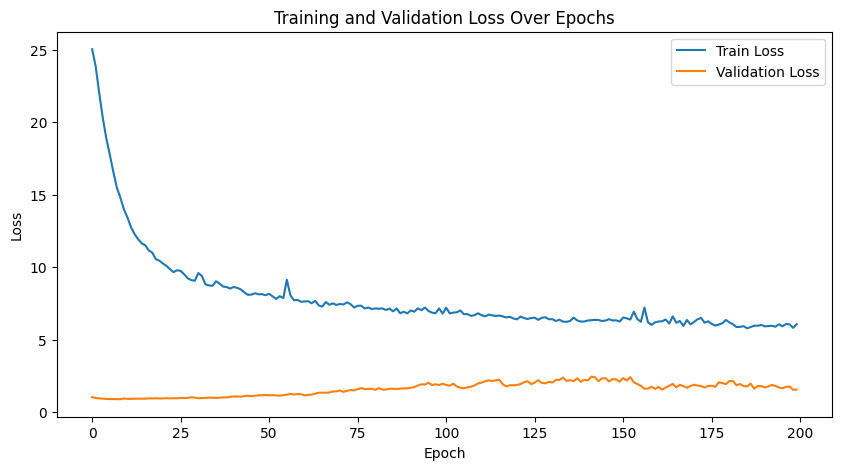

In [32]:

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'loss_curve.png'))
plt.show()


In [33]:
# Final predictions vs true values
model.eval()
with torch.no_grad():
    final_preds = model(X_val).numpy()
    true_vals = y_val.numpy()
    # Inverse transform to original scale
    final_preds = y_scaler.inverse_transform(final_preds)
    true_vals = y_scaler.inverse_transform(true_vals)


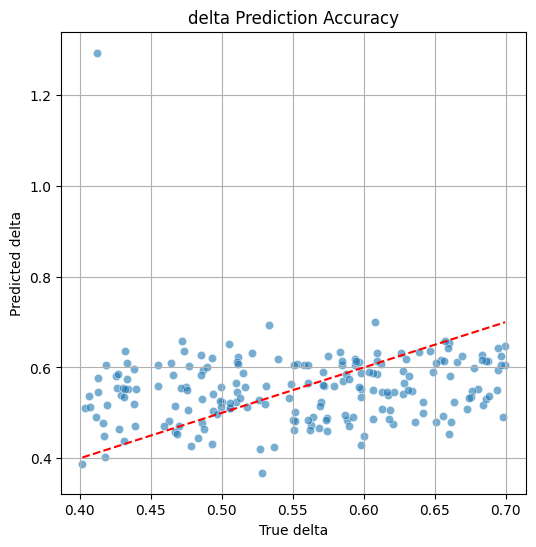

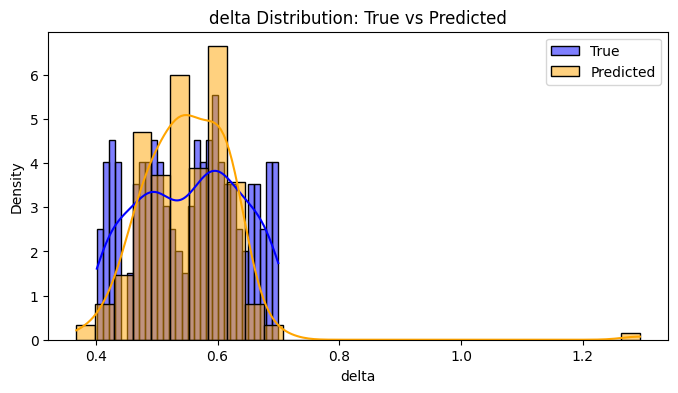

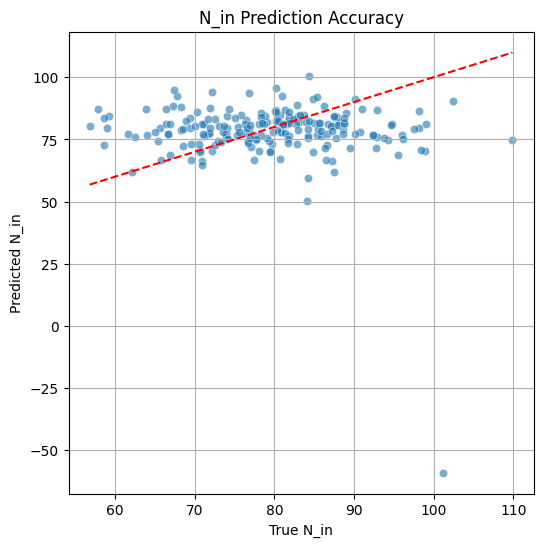

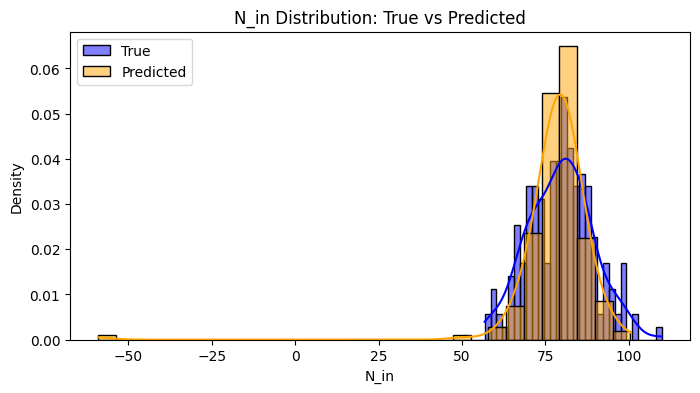

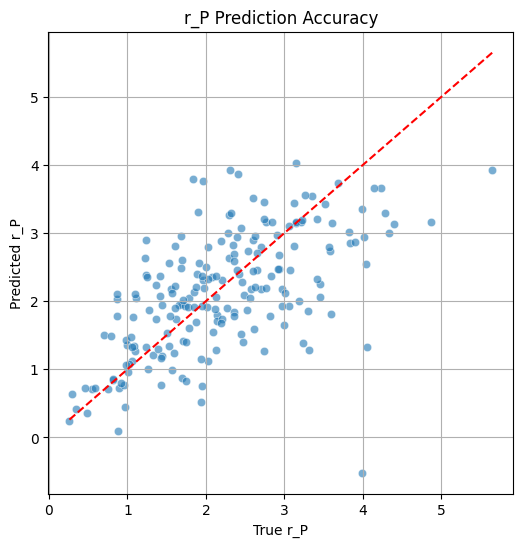

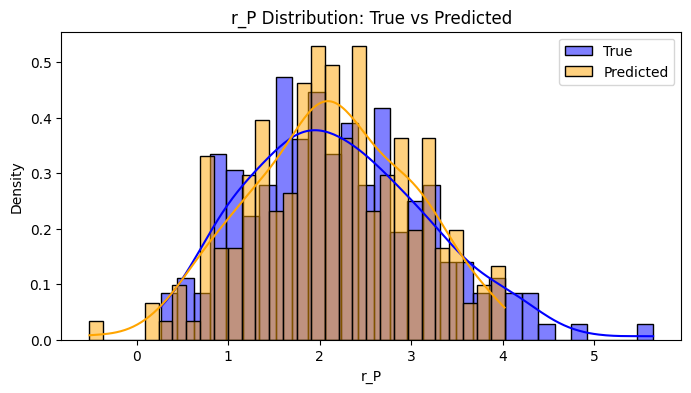

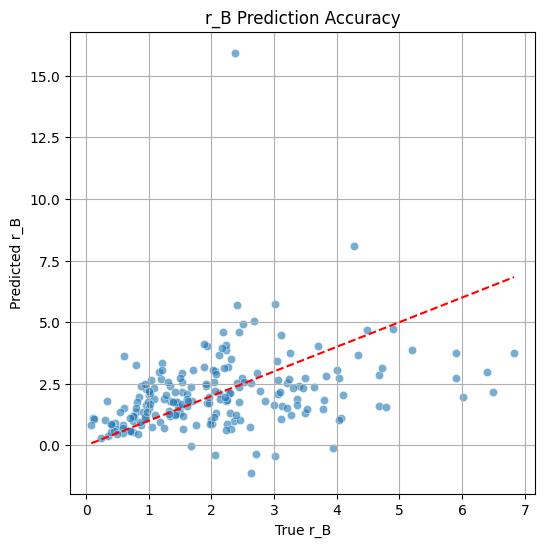

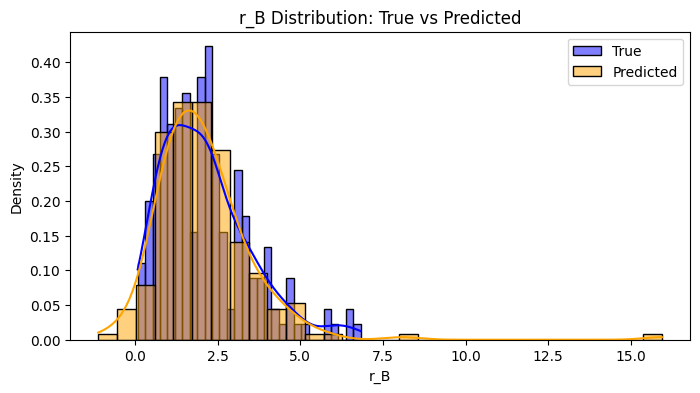

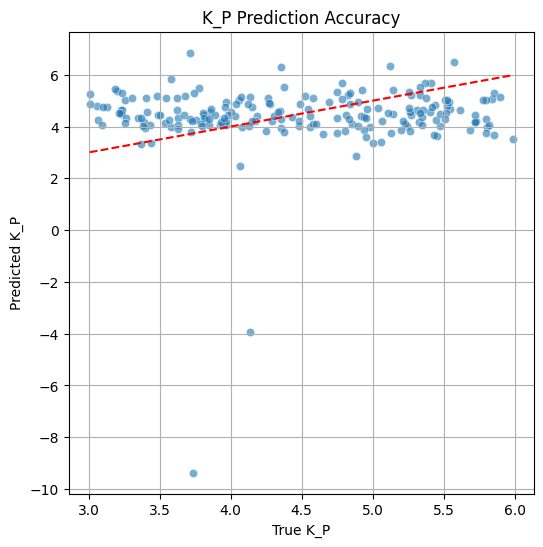

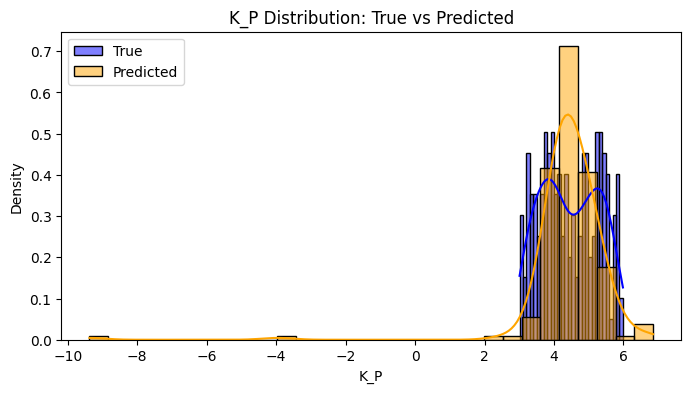

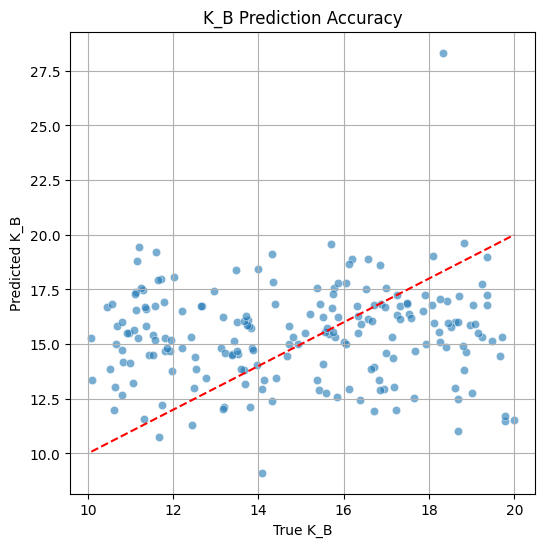

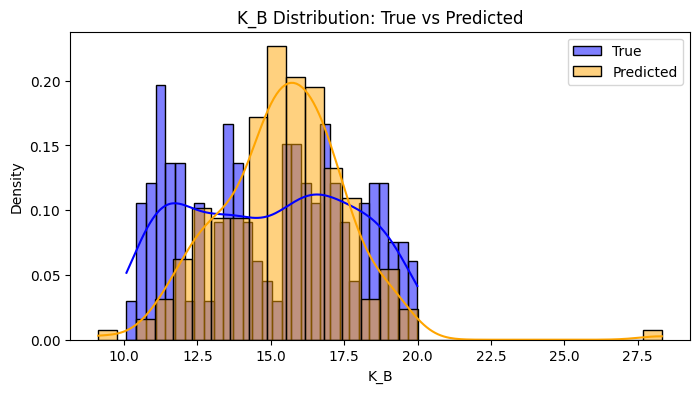

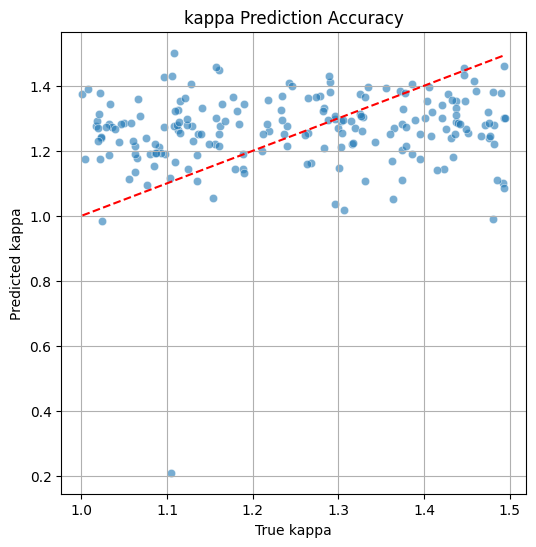

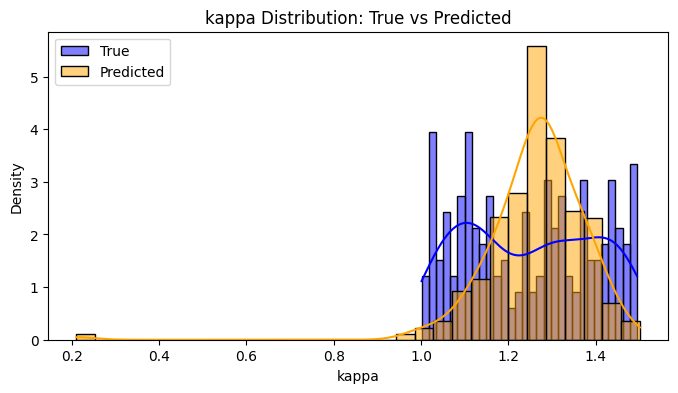

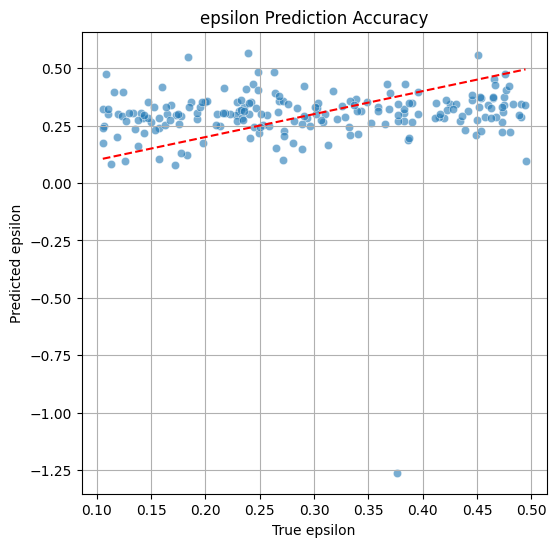

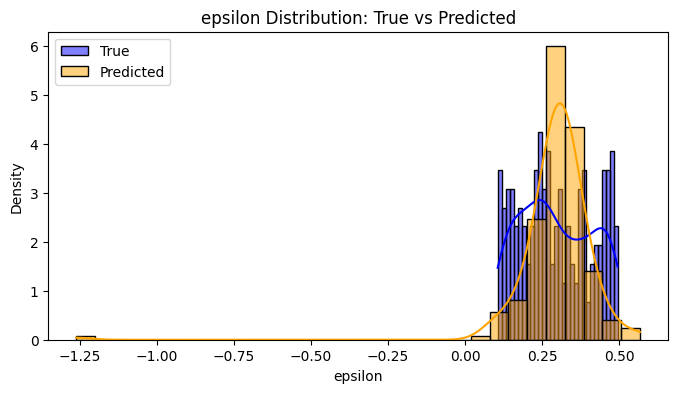

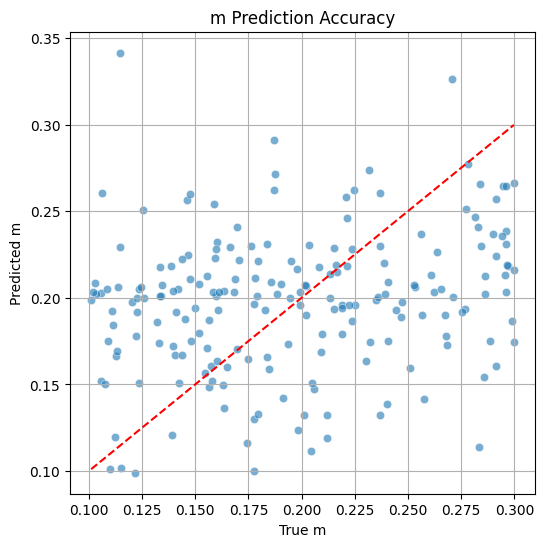

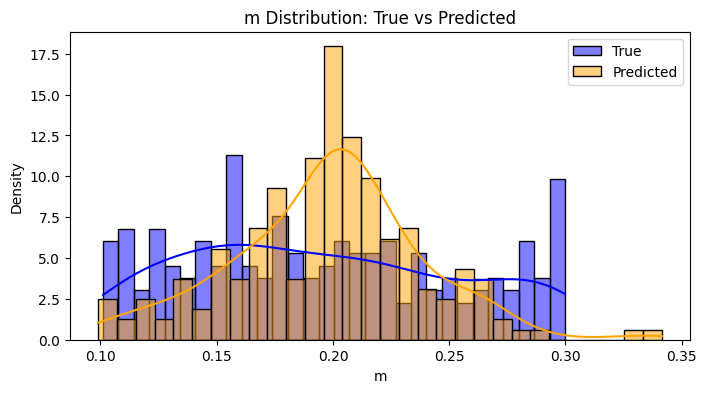

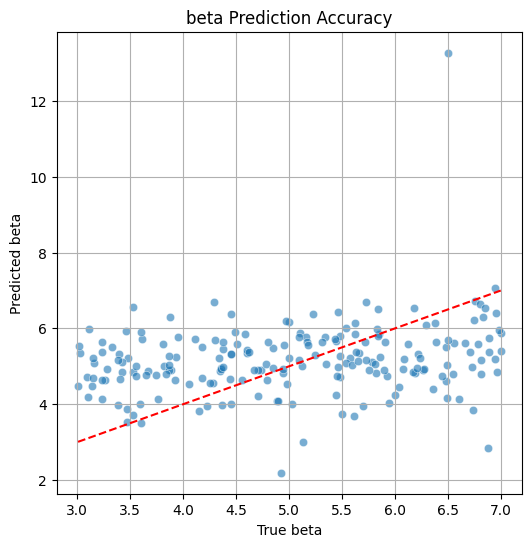

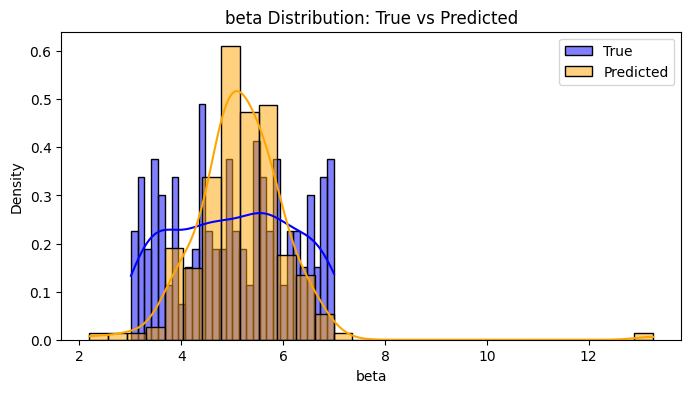

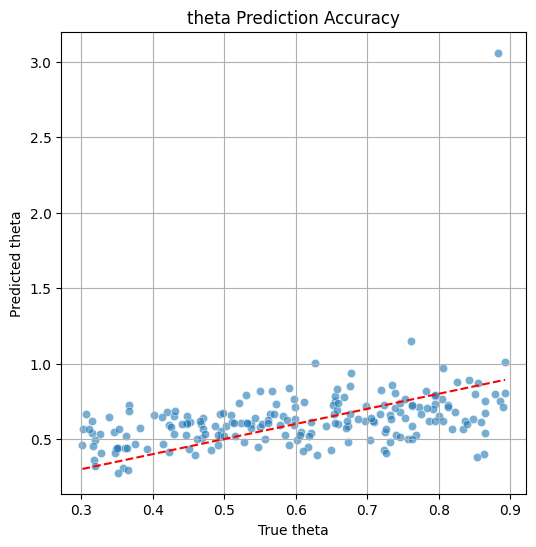

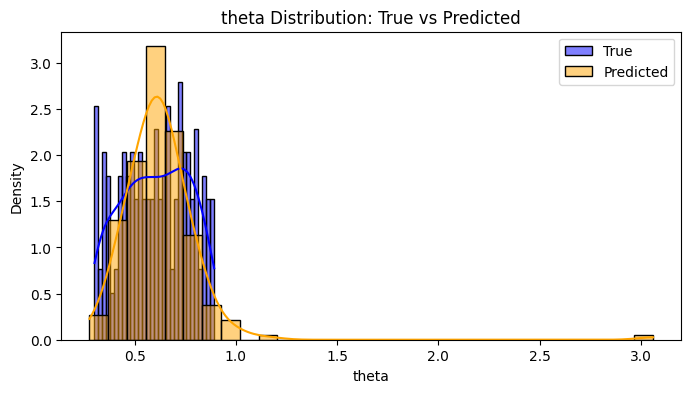

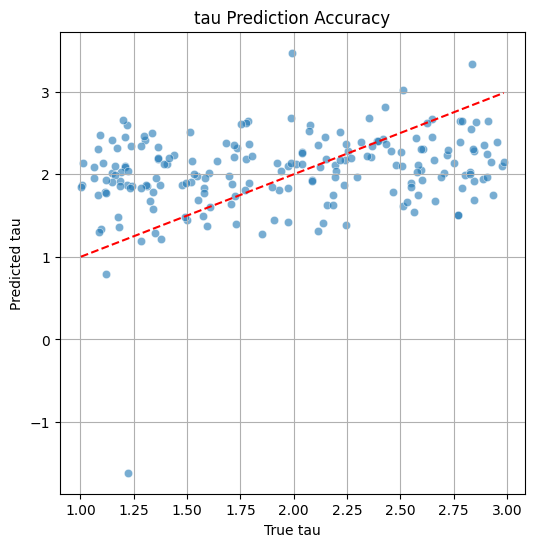

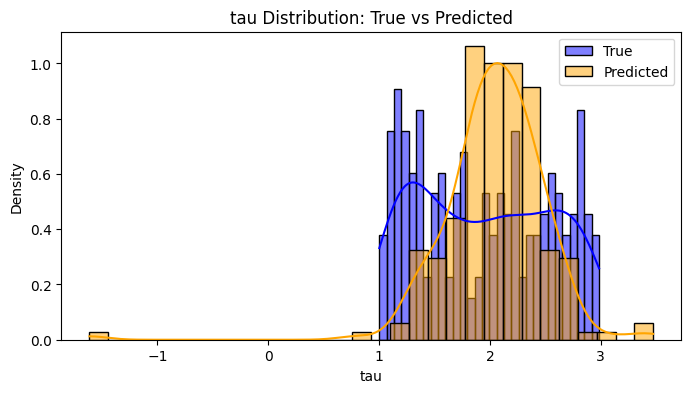

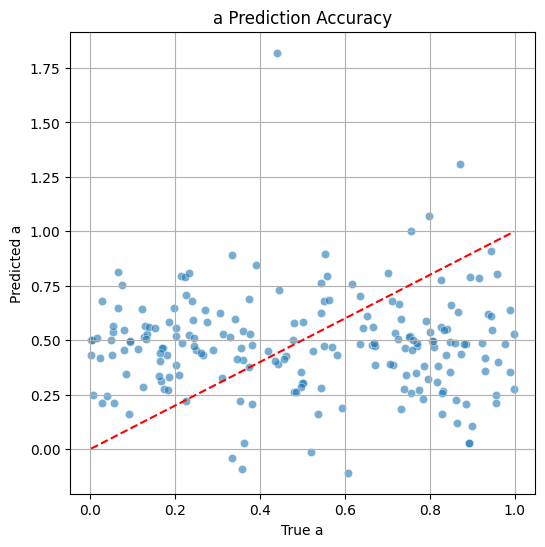

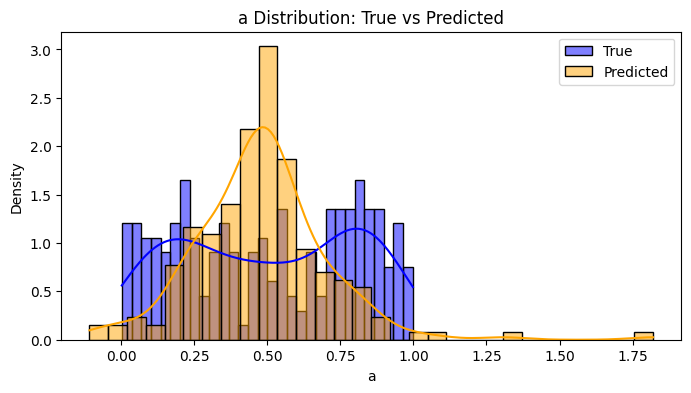

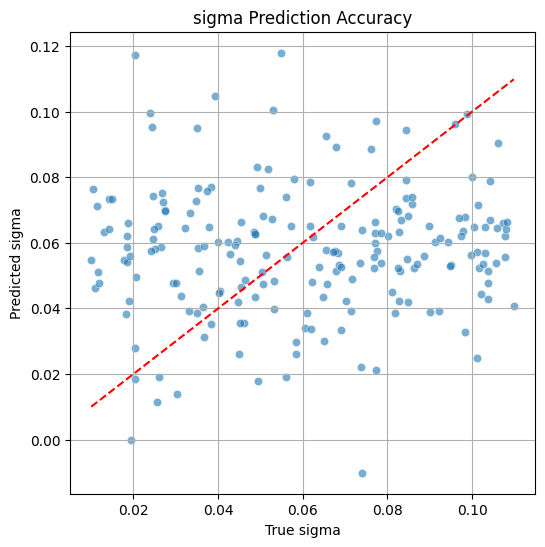

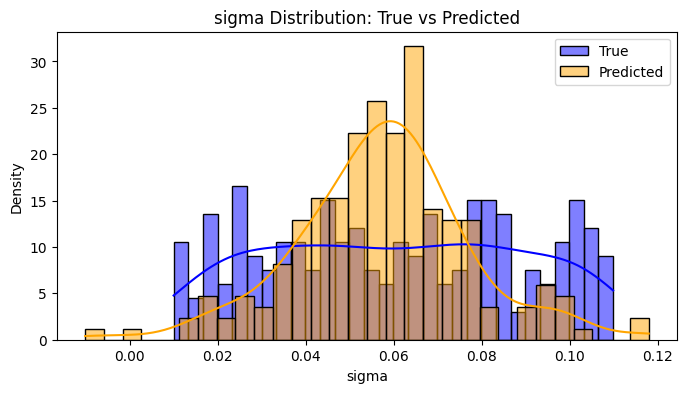

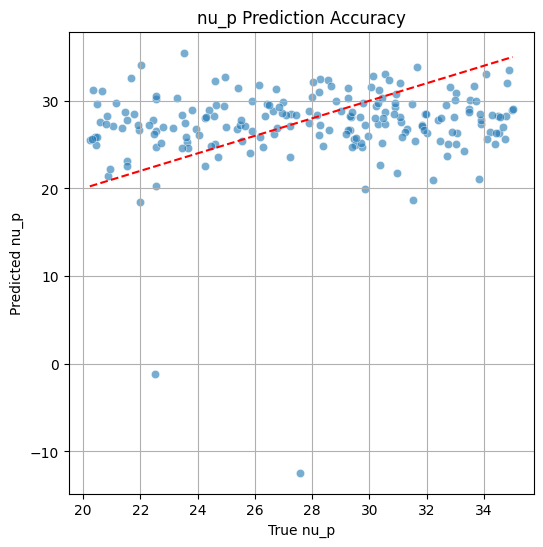

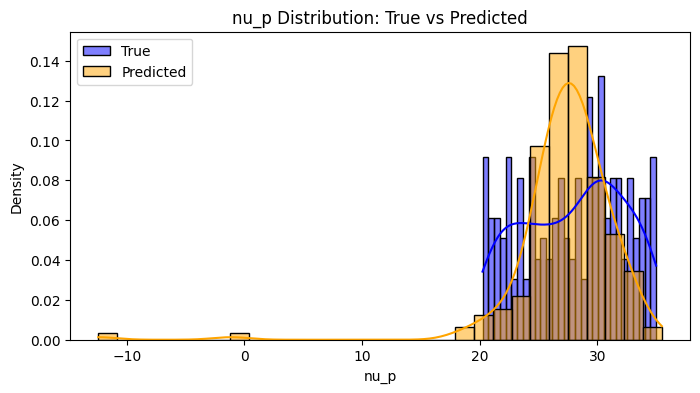

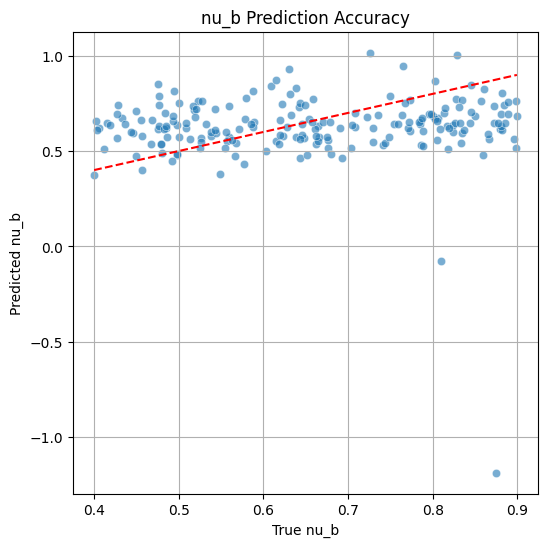

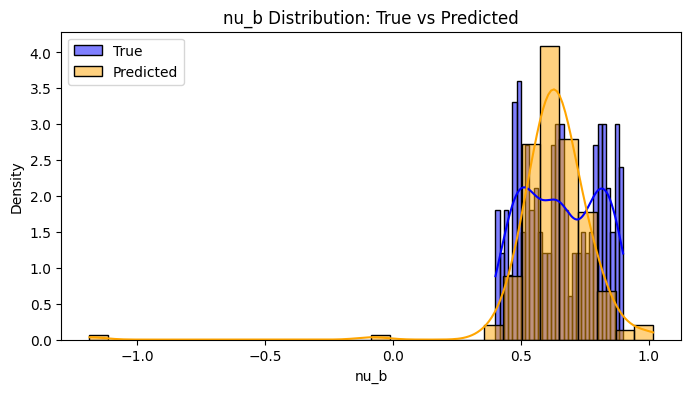

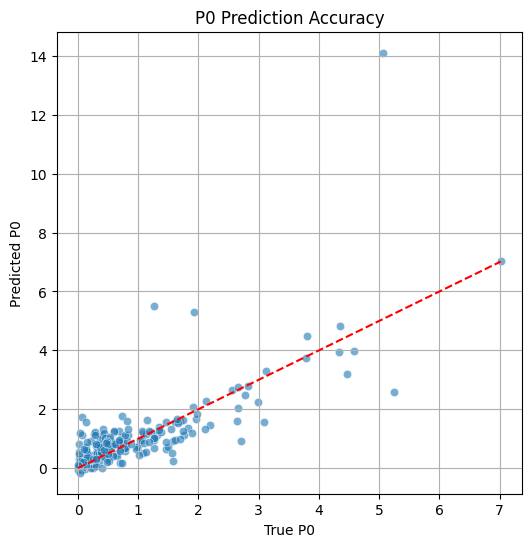

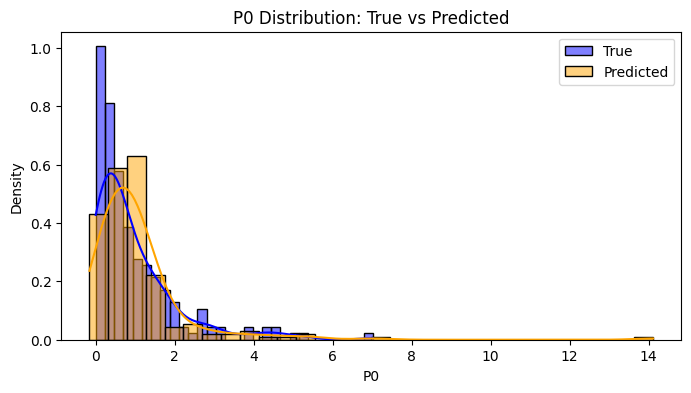

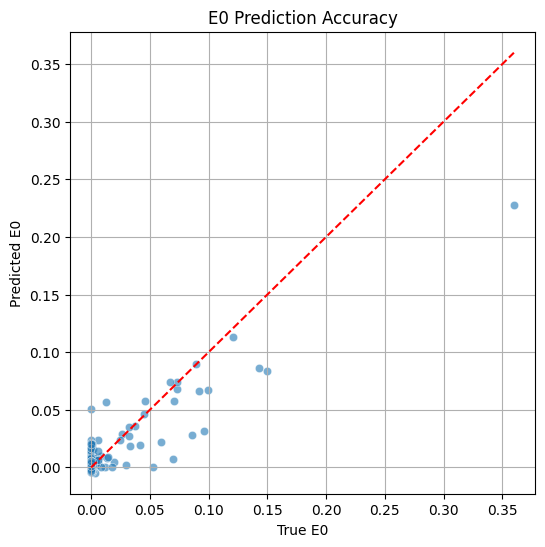

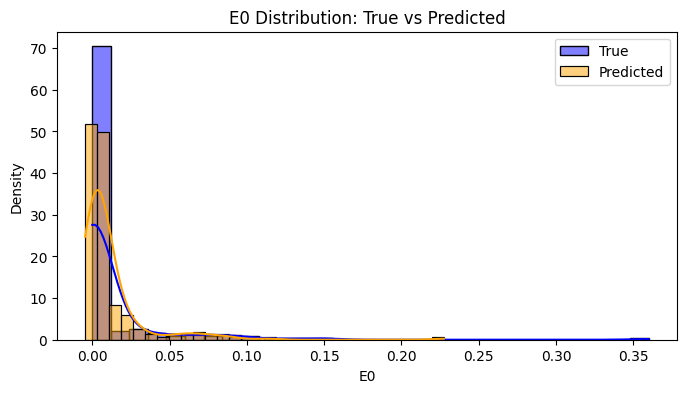

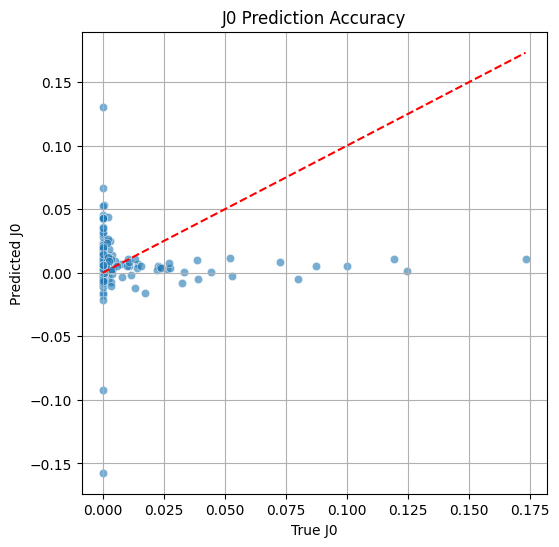

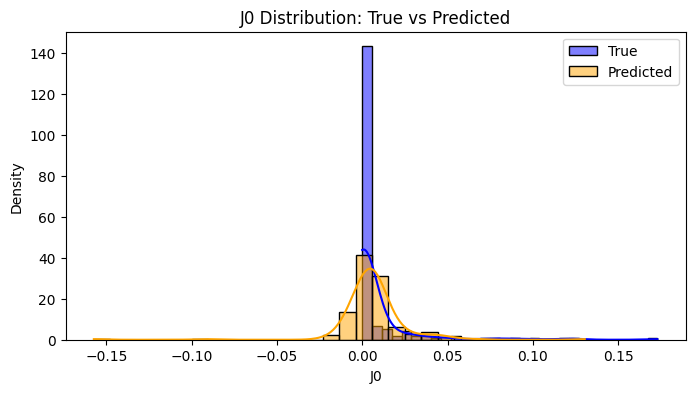

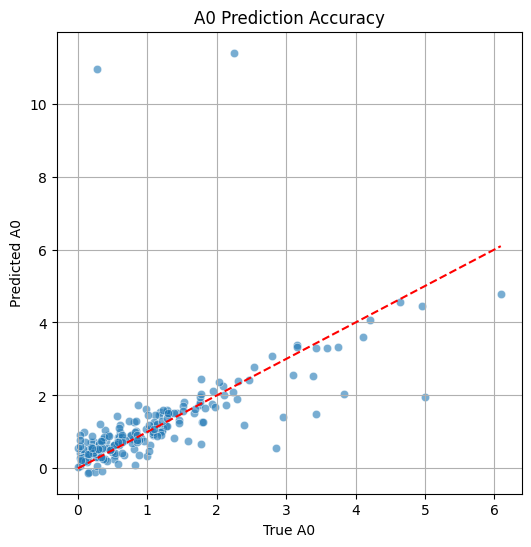

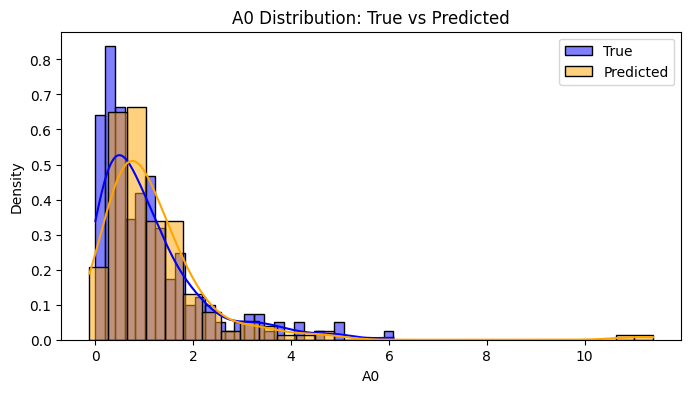

In [34]:
# Plot predicted vs true for each parameter and save histograms
for i, name in enumerate(param_names):
    # Scatter plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true_vals[:, i], y=final_preds[:, i], alpha=0.6)
    plt.plot([true_vals[:, i].min(), true_vals[:, i].max()],
                [true_vals[:, i].min(), true_vals[:, i].max()], '--r')
    plt.xlabel(f'True {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(f'{name} Prediction Accuracy')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, f'scatter_{name}.png'))
    plt.show()

    # Histogram comparison
    plt.figure(figsize=(8, 4))
    sns.histplot(true_vals[:, i], label='True', color='blue', kde=True, stat="density", bins=30)
    sns.histplot(final_preds[:, i], label='Predicted', color='orange', kde=True, stat="density", bins=30)
    plt.title(f'{name} Distribution: True vs Predicted')
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f'distribution_{name}.png'))
    plt.show()


In [35]:
def load_two_datasets(randomized_path, random_param_path, nonrandomized_path, nonrandom_param_path):
    X_rand, y_rand, param_names = load_simulation_data(randomized_path, random_param_path)
    X_nonrand, y_nonrand, _ = load_simulation_data(nonrandomized_path, nonrandom_param_path)
    return (X_rand, y_rand), (X_nonrand, y_nonrand), param_names

In [36]:
(rand_X, rand_y), (nonrand_X, nonrand_y), param_names = load_two_datasets(
    randomized_path="../data/new_data/randomized/randomized/",
    random_param_path="../data/new_data/FullPredatorPreyModel_params_randomized.json",
    nonrandomized_path="../data/new_data/non-randomized/non-randomized/",
    nonrandom_param_path="../data/new_data/FullPredatorPreyModel_params.json"
)


In [39]:
epochs = 100

In [41]:
save_dir="../results/nn_results/simDataResults"

[randomized] Max: 2271603251.34456, Min: 0.0, Any NaN? False, Any Inf? False
Epoch   0 | Mode: randomized    | Train Loss: 1.0183 | Val Loss: 1.0115
Epoch  10 | Mode: randomized    | Train Loss: 0.9481 | Val Loss: 0.9470
Epoch  20 | Mode: randomized    | Train Loss: 0.8899 | Val Loss: 0.9005
Epoch  30 | Mode: randomized    | Train Loss: 0.8397 | Val Loss: 0.8653
Epoch  40 | Mode: randomized    | Train Loss: 0.7935 | Val Loss: 0.8343
Epoch  50 | Mode: randomized    | Train Loss: 0.7544 | Val Loss: 0.8084
Epoch  60 | Mode: randomized    | Train Loss: 0.7192 | Val Loss: 0.7932
Epoch  70 | Mode: randomized    | Train Loss: 0.6937 | Val Loss: 0.7893
Early stopping triggered at epoch 78


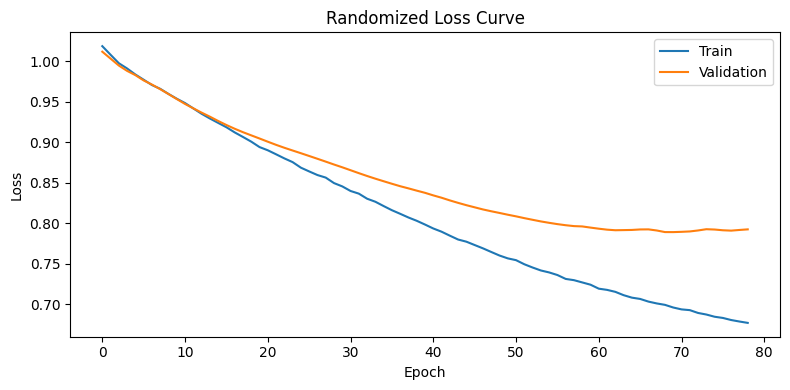

[nonrandomized] Max: 1.0474228844636062e+289, Min: 0.0, Any NaN? False, Any Inf? False
Epoch   0 | Mode: nonrandomized | Train Loss: 1.0137 | Val Loss: 1.0124
Epoch  10 | Mode: nonrandomized | Train Loss: 0.9315 | Val Loss: 0.9335
Epoch  20 | Mode: nonrandomized | Train Loss: 0.8951 | Val Loss: 0.9018
Epoch  30 | Mode: nonrandomized | Train Loss: 0.8639 | Val Loss: 0.8763
Epoch  40 | Mode: nonrandomized | Train Loss: 0.8369 | Val Loss: 0.8507
Epoch  50 | Mode: nonrandomized | Train Loss: 0.8137 | Val Loss: 0.8252
Epoch  60 | Mode: nonrandomized | Train Loss: 0.7855 | Val Loss: 0.7950
Epoch  70 | Mode: nonrandomized | Train Loss: 0.7629 | Val Loss: 0.7725
Epoch  80 | Mode: nonrandomized | Train Loss: 0.7441 | Val Loss: 0.7518
Epoch  90 | Mode: nonrandomized | Train Loss: 0.7298 | Val Loss: 0.7404


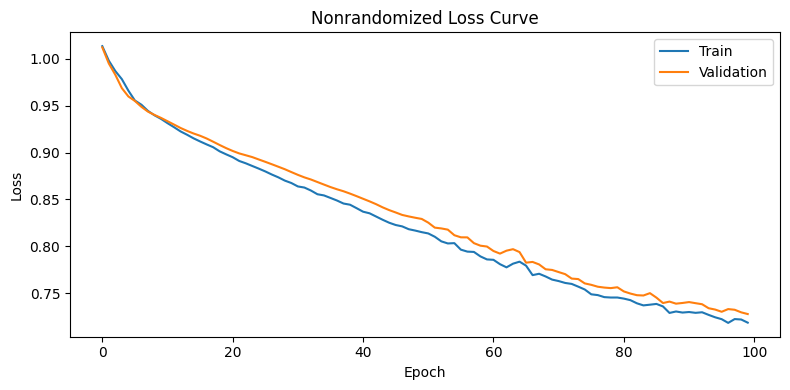

In [45]:
os.makedirs(save_dir, exist_ok=True)
results = {}

for label, (X, y) in zip(['randomized', 'nonrandomized'], [(rand_X, rand_y), (nonrand_X, nonrand_y)]):
    # Pre-scaling checks and cleaning
    print(f"[{label}] Max: {np.max(X)}, Min: {np.min(X)}, Any NaN? {np.isnan(X).any()}, Any Inf? {np.isinf(X).any()}")
    X = np.clip(np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6), -1e6, 1e6)
    y = np.clip(np.nan_to_num(y, nan=0.0, posinf=1e6, neginf=-1e6), -1e6, 1e6)

    # Normalize
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X = x_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    model = ABCParameterNet(X.shape[1], y.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    wait = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Mode: {label:13s} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping condition
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    results[label] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model': model,
        'x_scaler': x_scaler,
        'y_scaler': y_scaler
    }

    # Plot loss curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(f"{label.capitalize()} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{label}_loss_curve.png"))
    plt.show()

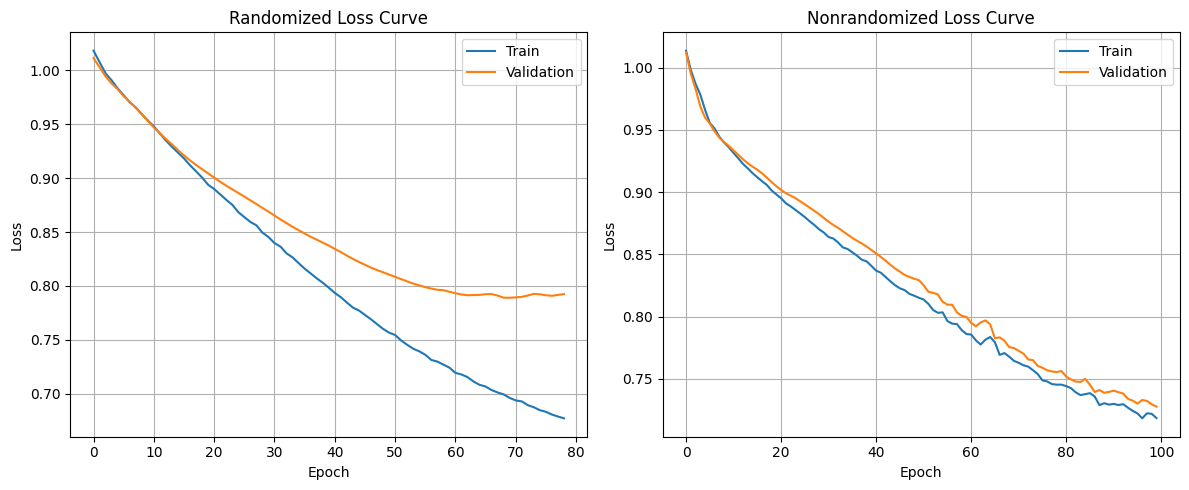

In [47]:
# Plot both loss curves in a 2-column grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, label in zip(axes, results.keys()):
    train_losses = results[label]['train_losses']
    val_losses = results[label]['val_losses']
    
    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Validation')
    ax.set_title(f"{label.capitalize()} Loss Curve")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "combined_loss_curves.png"), dpi=300)
plt.show()


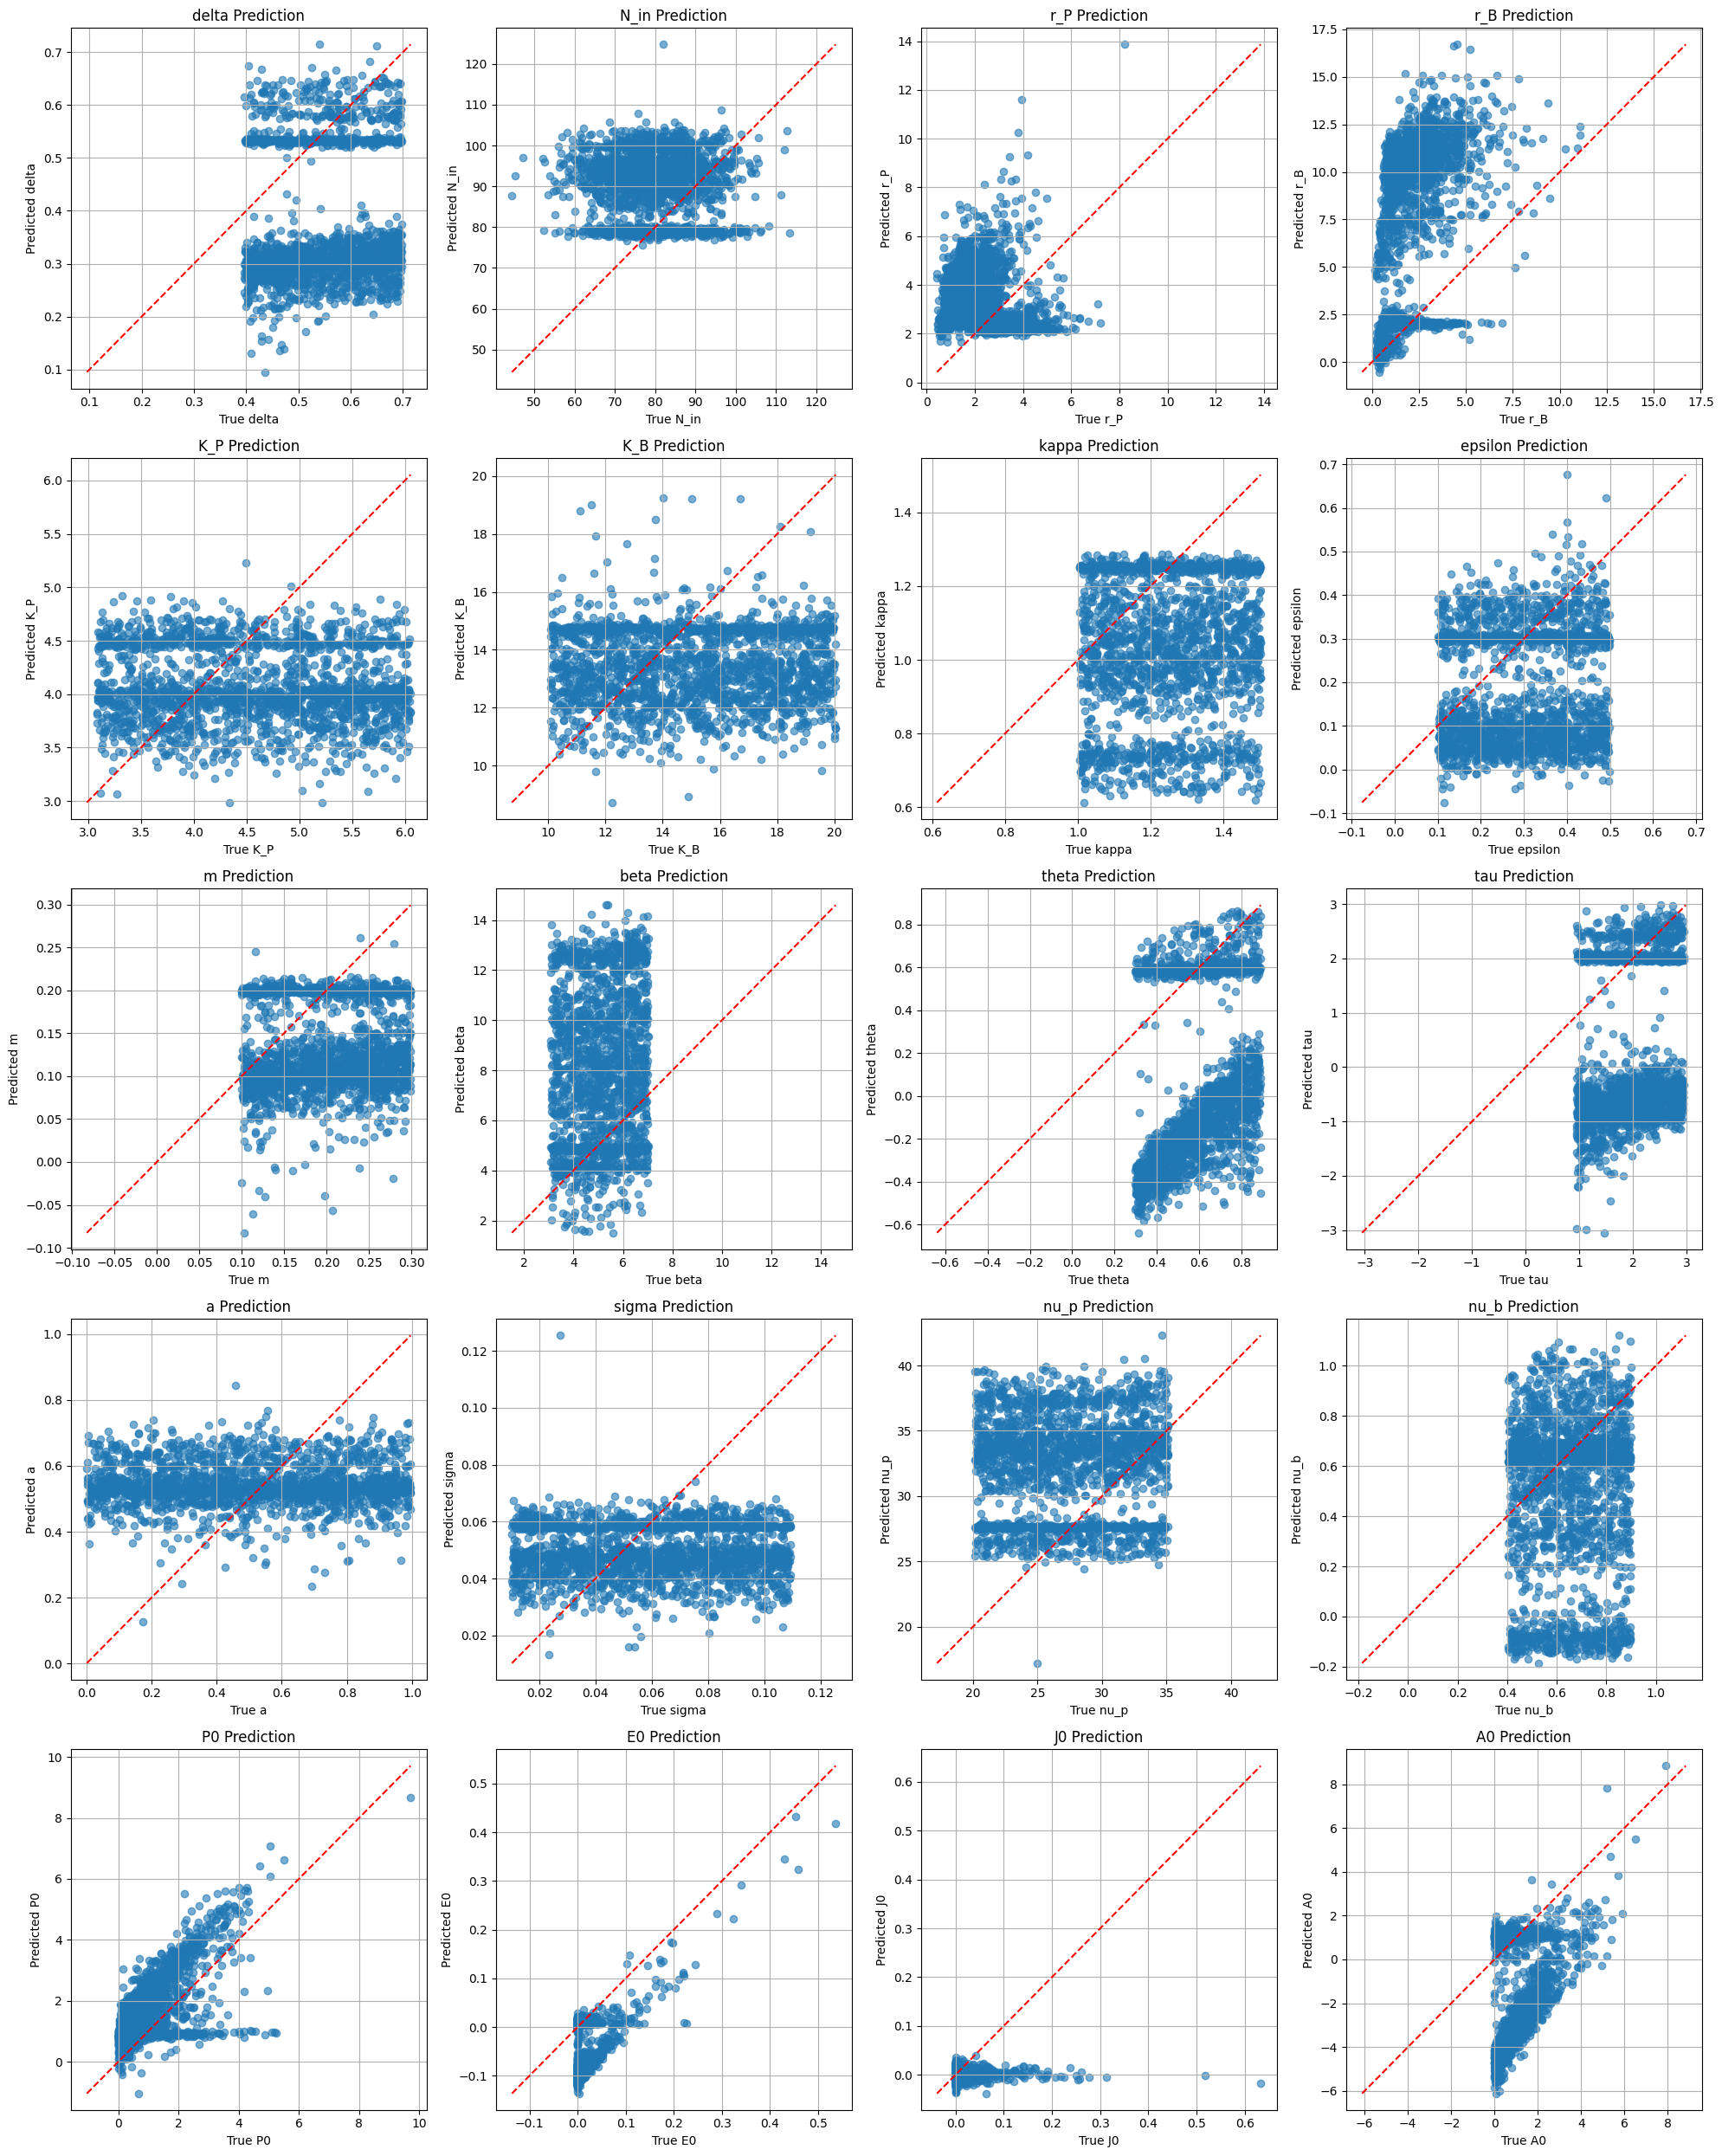

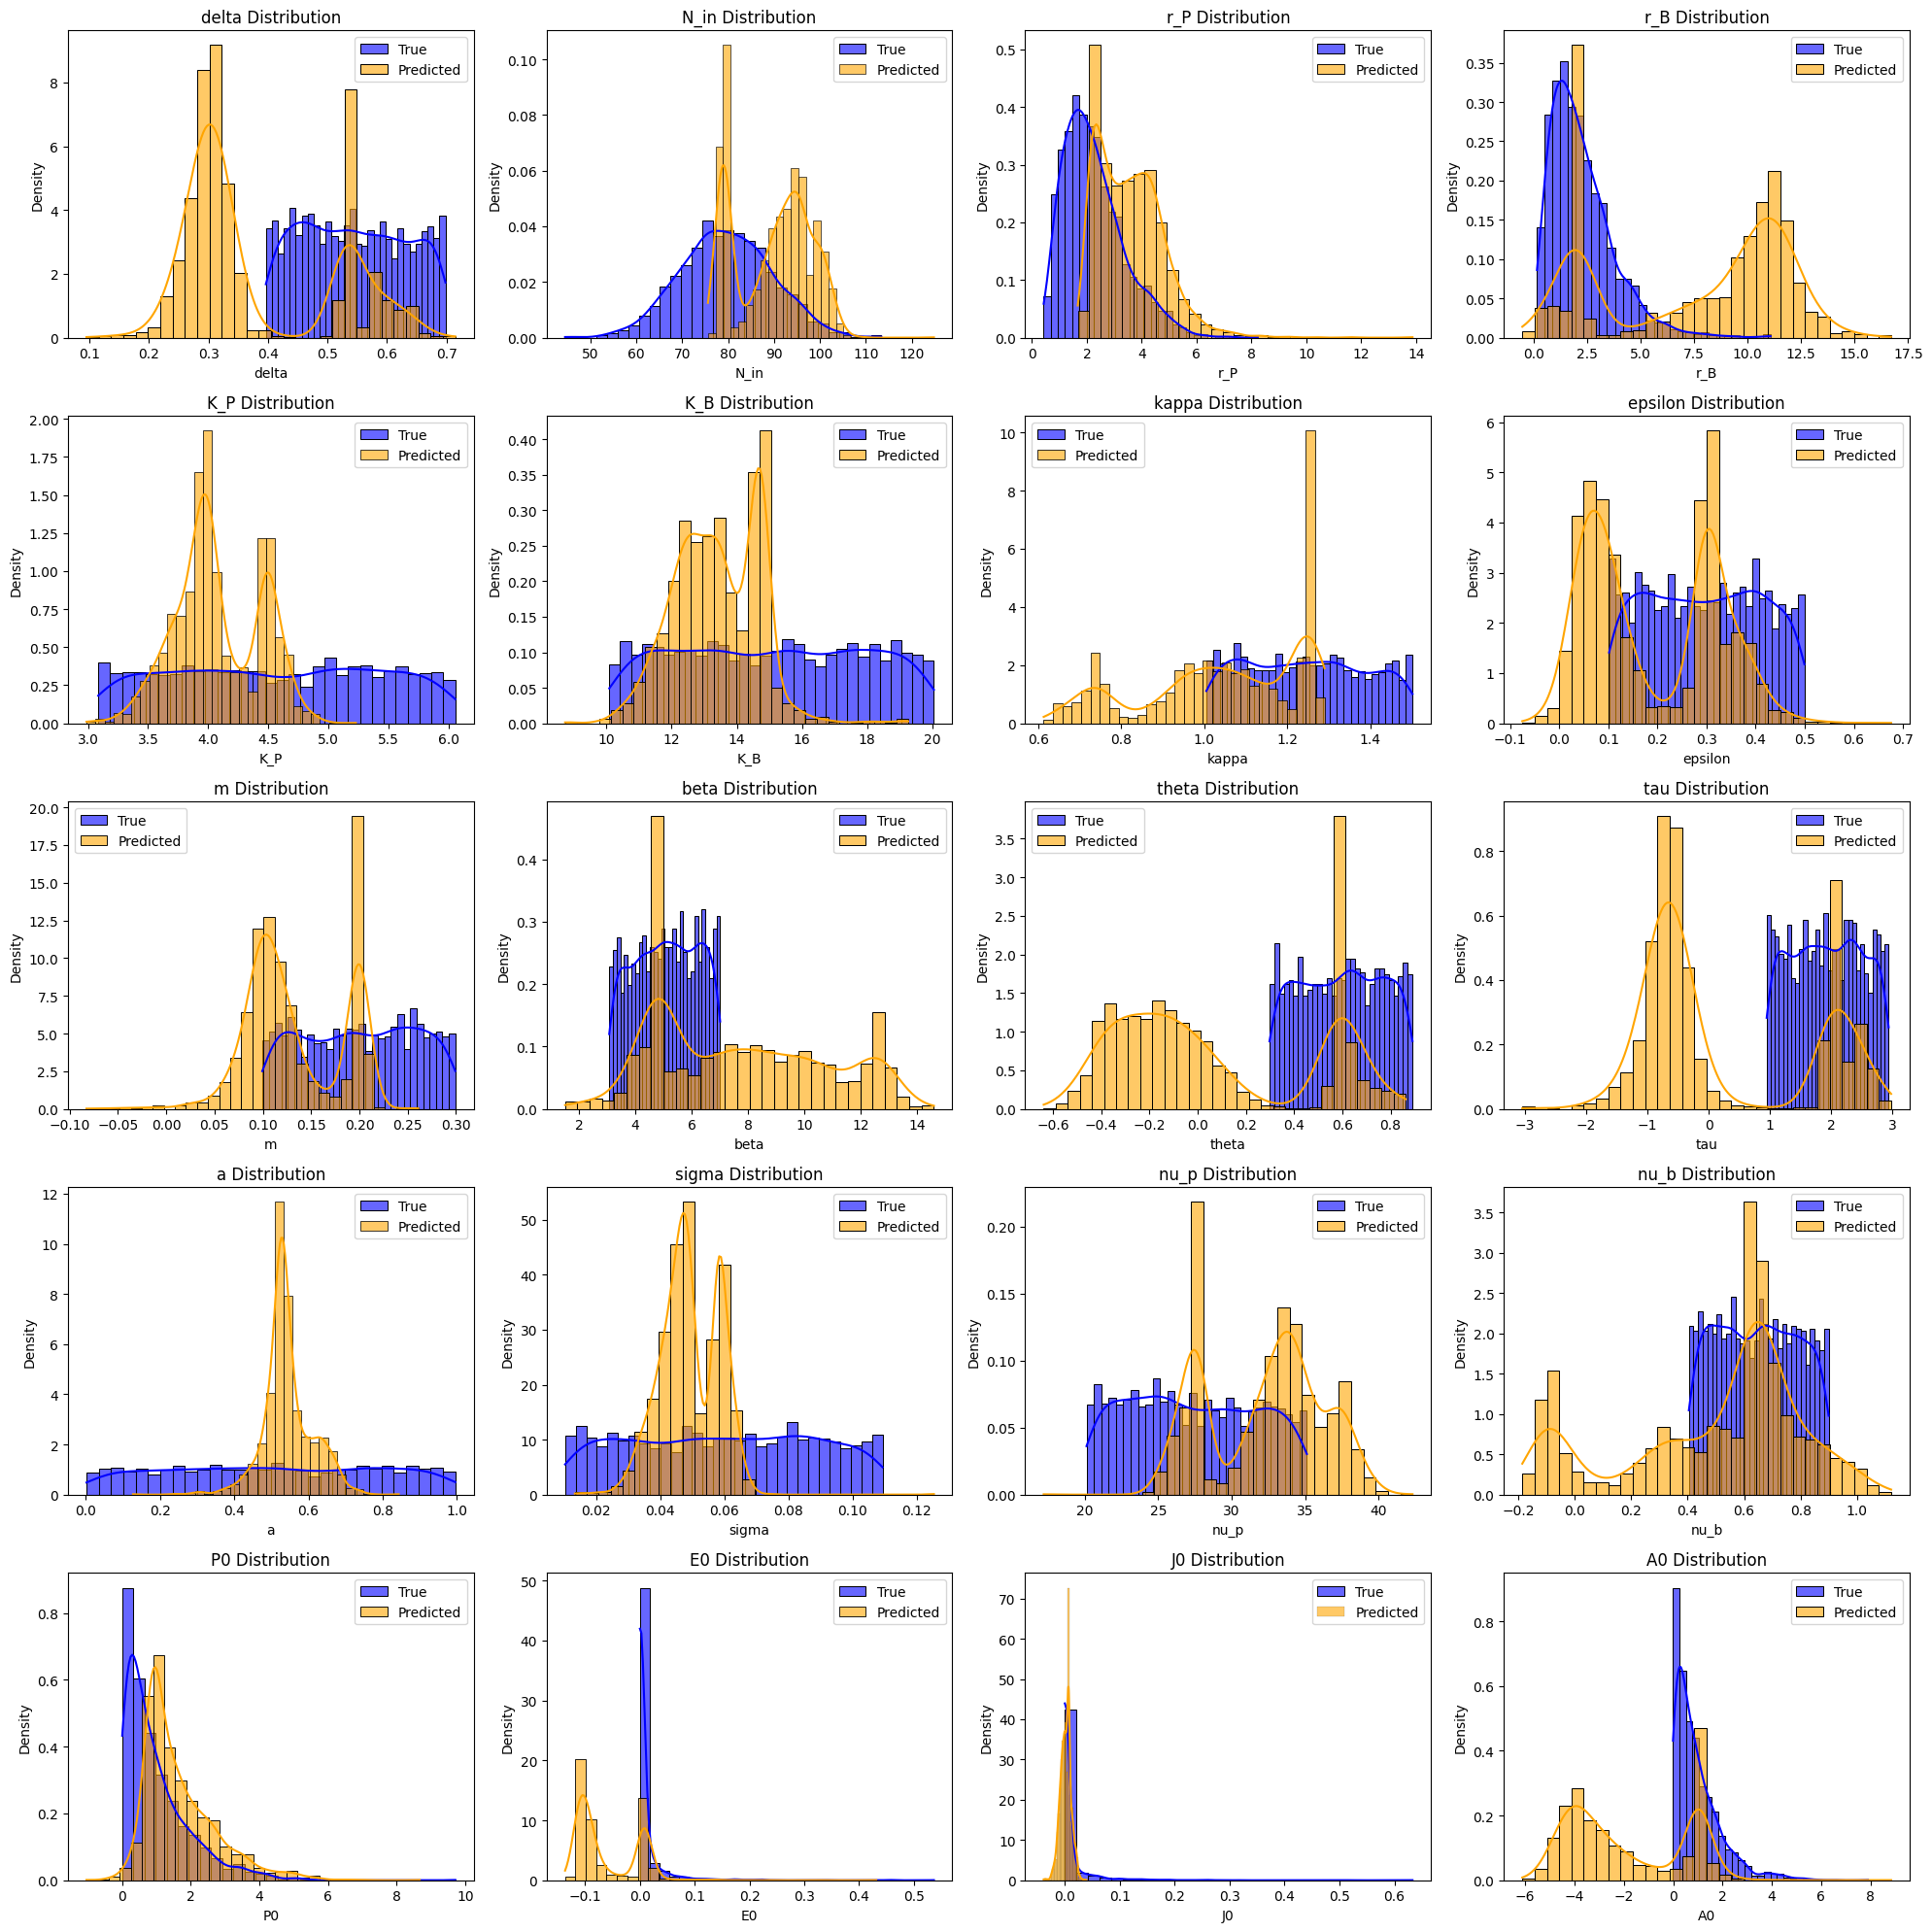

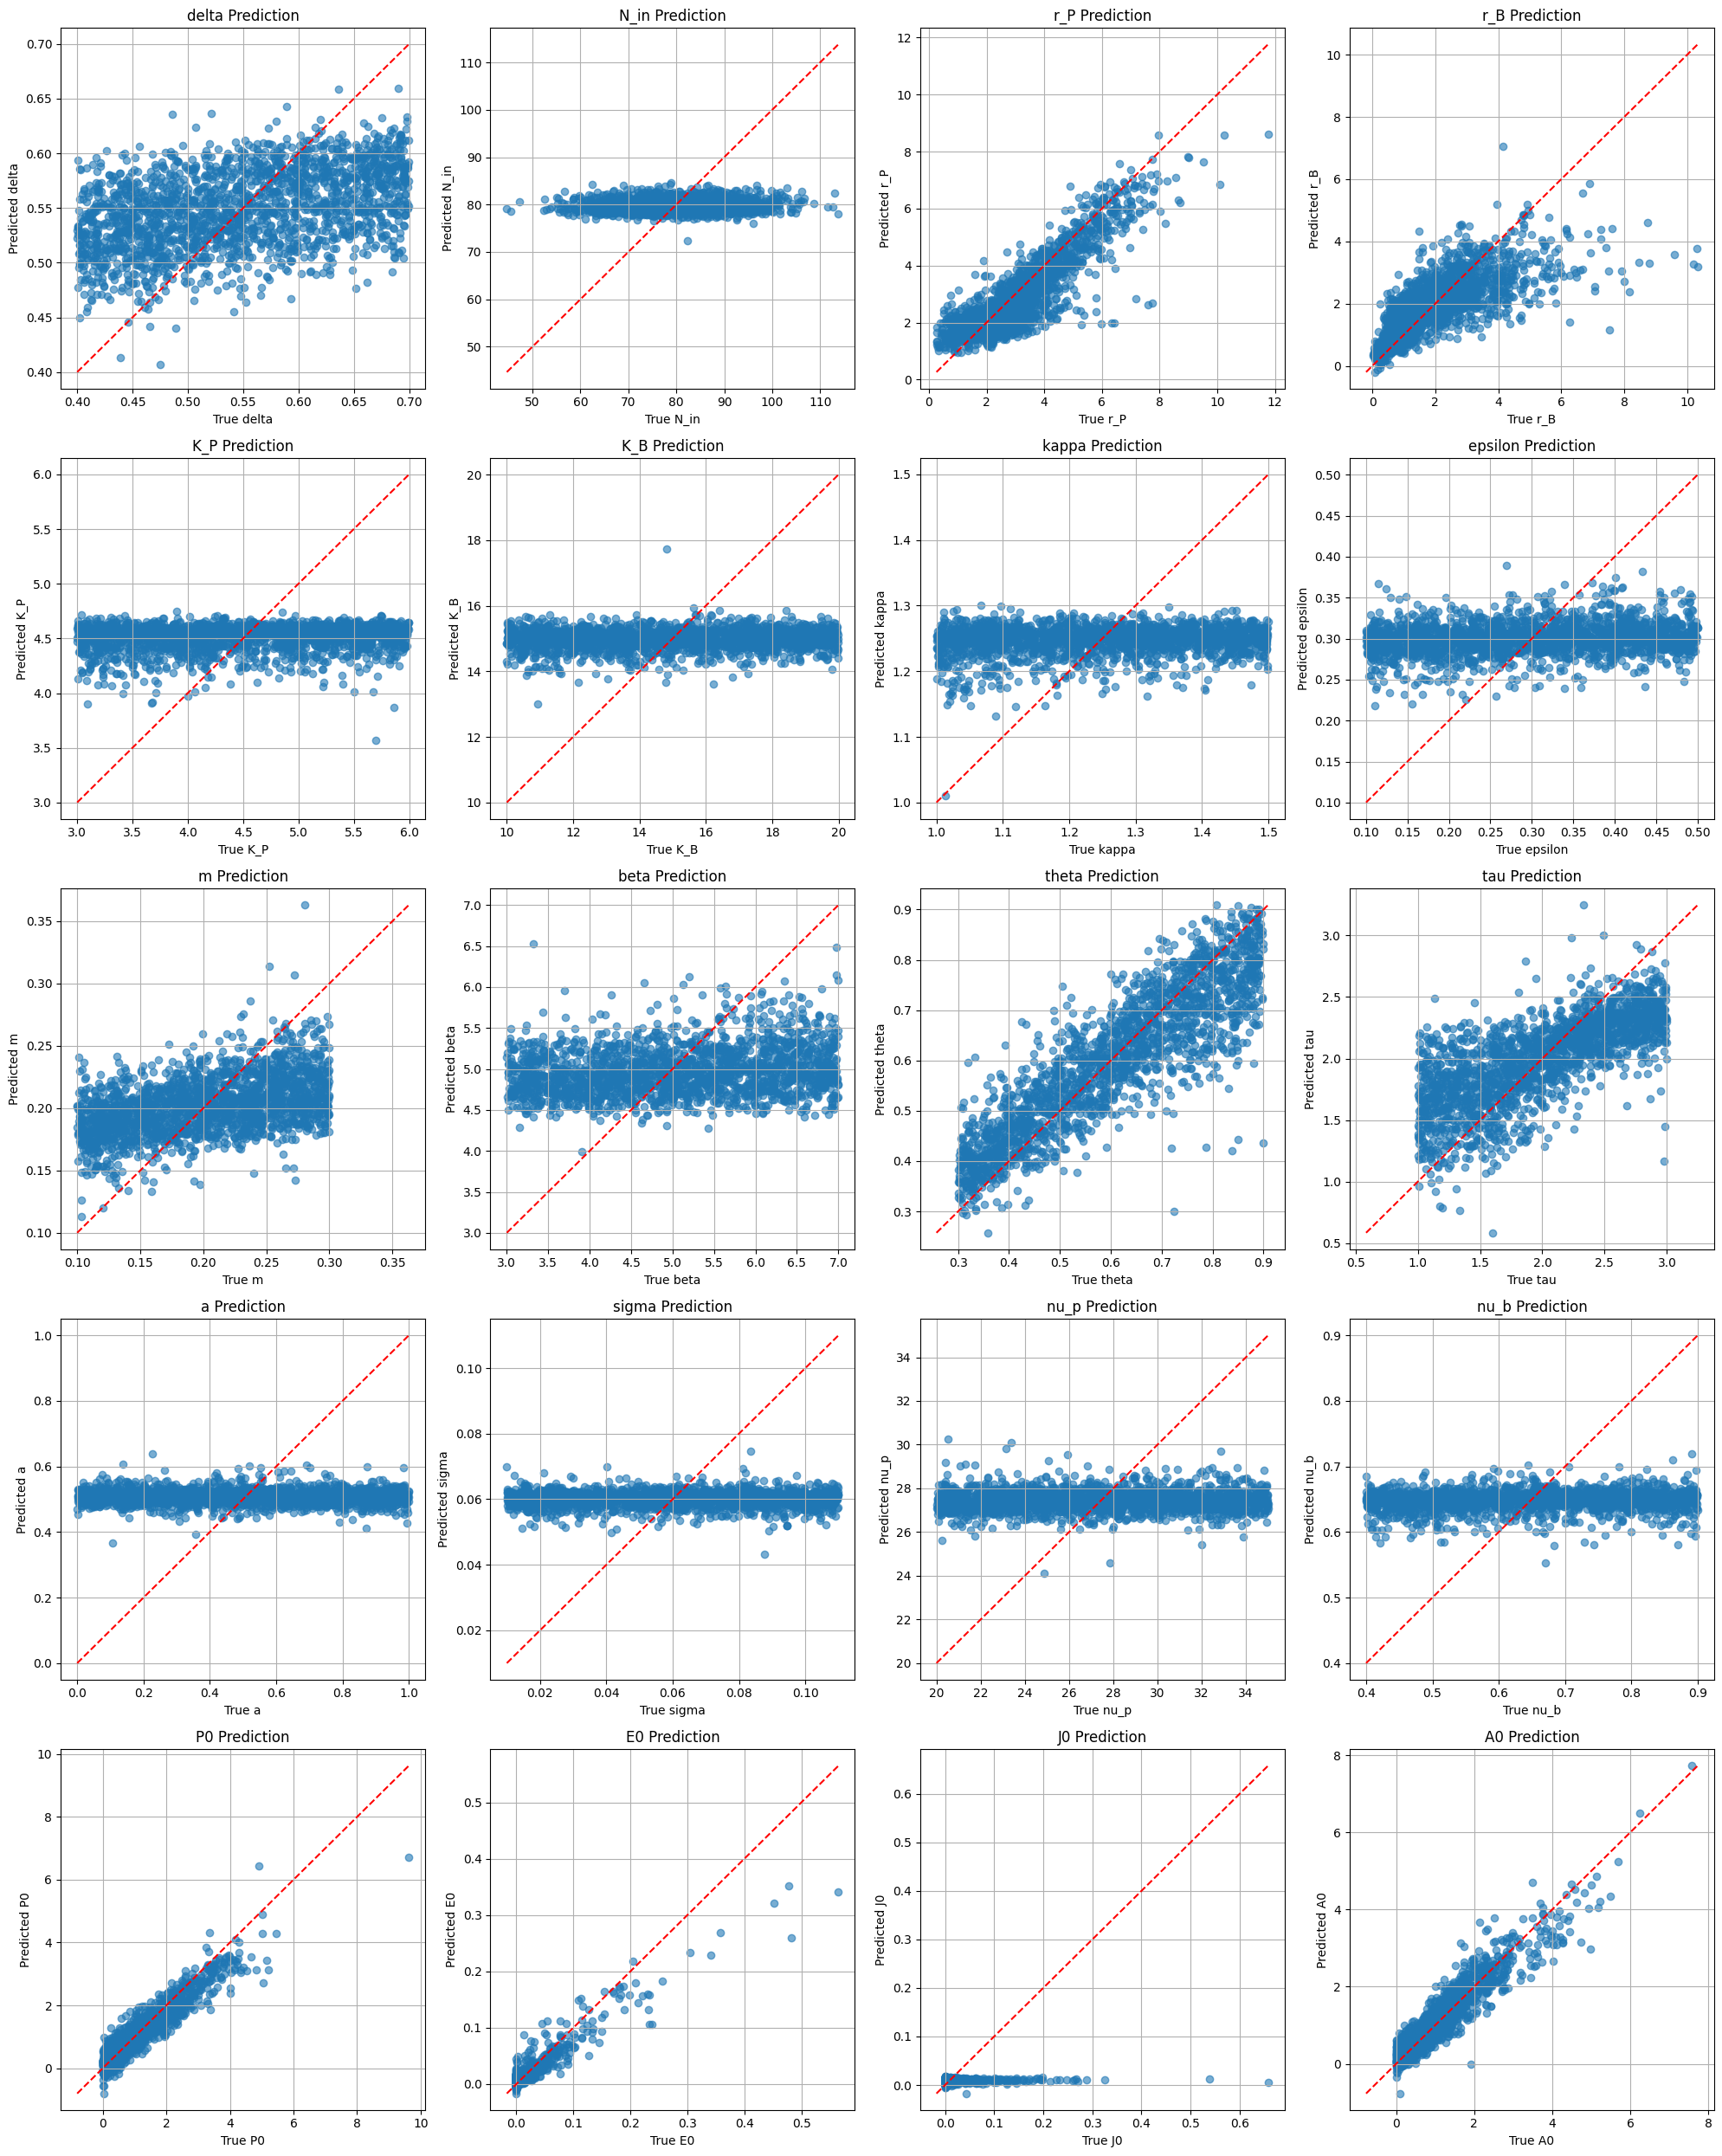

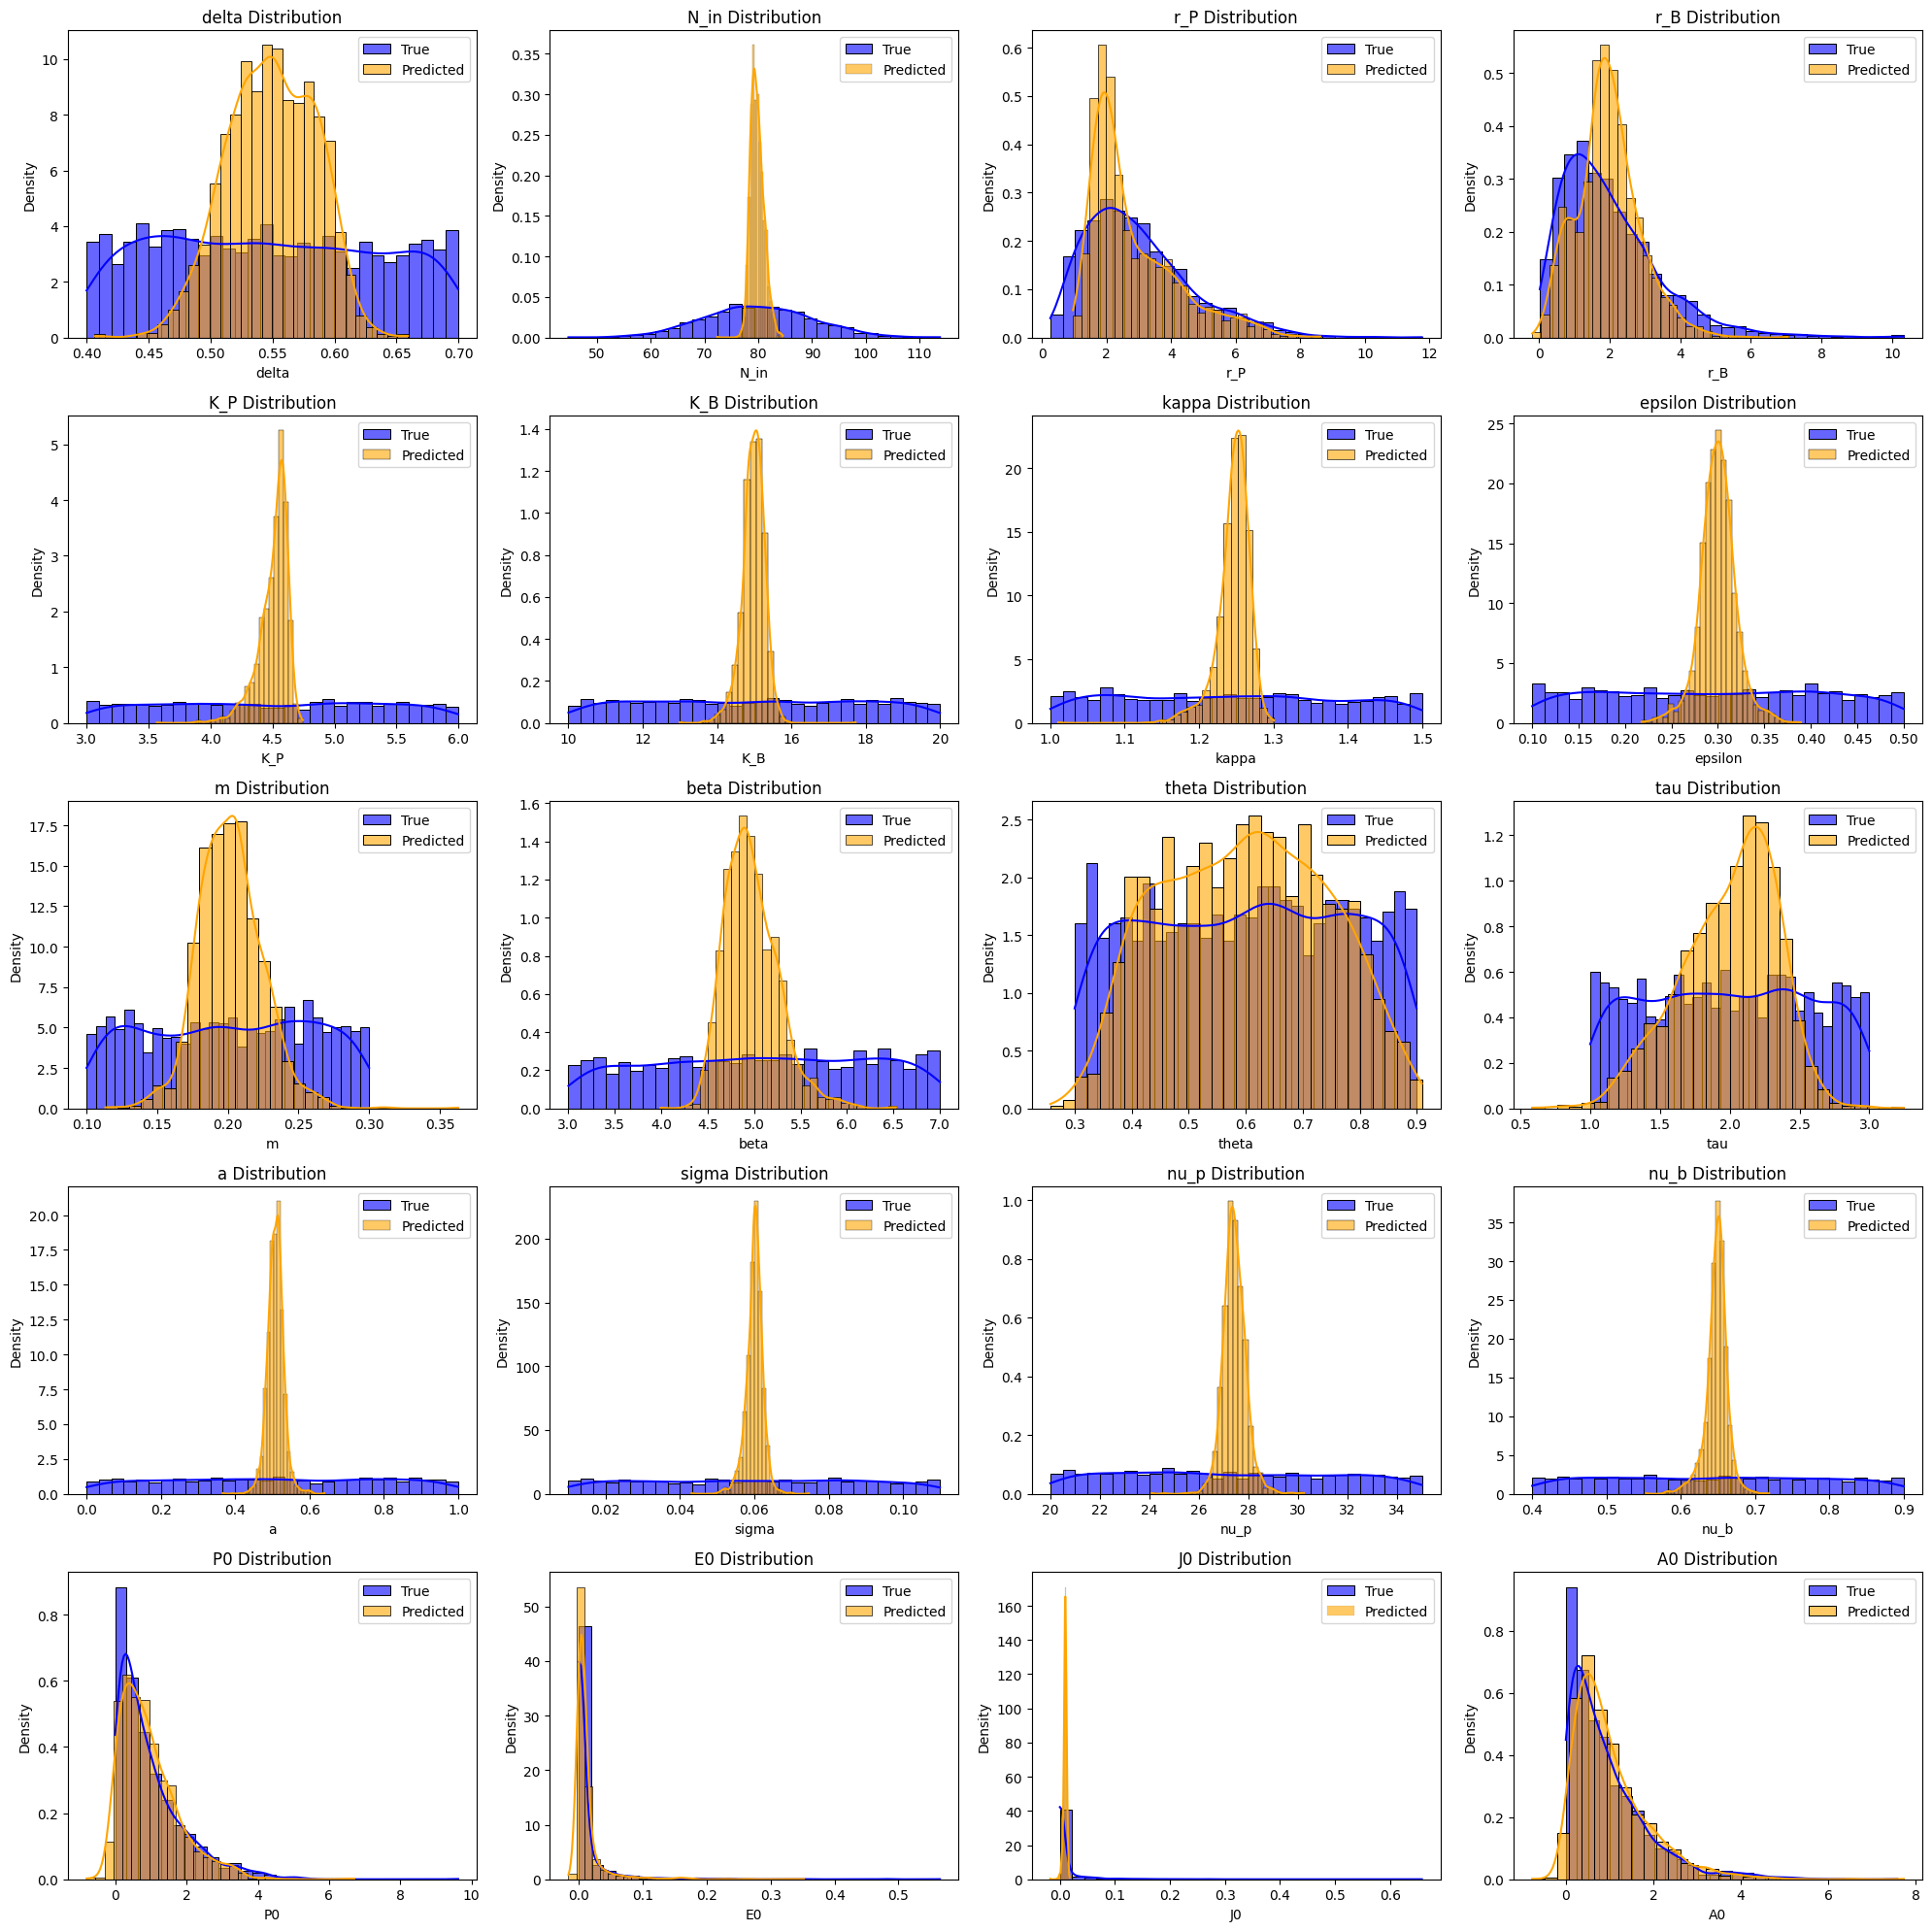

In [46]:
import math

for label in results:
    model = results[label]['model']
    x_scaler = results[label]['x_scaler']
    y_scaler = results[label]['y_scaler']

    model.eval()
    with torch.no_grad():
        final_preds = model(X_val).numpy()
        true_vals = y_val.numpy()

    # Inverse transform to original scale
    final_preds = y_scaler.inverse_transform(final_preds)
    true_vals = y_scaler.inverse_transform(true_vals)

    n_params = len(param_names)
    n_cols = 4
    n_rows = math.ceil(n_params / n_cols)

    # --------------------------
    # 1. SCATTER PLOT GRID (4 columns)
    # --------------------------
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for i, name in enumerate(param_names):
        ax = axes[i]
        ax.scatter(true_vals[:, i], final_preds[:, i], alpha=0.6)
        lims = [
            min(true_vals[:, i].min(), final_preds[:, i].min()),
            max(true_vals[:, i].max(), final_preds[:, i].max())
        ]
        ax.plot(lims, lims, '--r')
        ax.set_xlabel(f'True {name}')
        ax.set_ylabel(f'Predicted {name}')
        ax.set_title(f'{name} Prediction')
        ax.grid(True)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{label}_scatter_grid.png'), dpi=300)
    plt.show()

    # --------------------------
    # 2. HISTOGRAM PLOT GRID (4 columns)
    # --------------------------
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, name in enumerate(param_names):
        ax = axes[i]
        sns.histplot(true_vals[:, i], label='True', color='blue', kde=True, stat="density", bins=30, alpha=0.6, ax=ax)
        sns.histplot(final_preds[:, i], label='Predicted', color='orange', kde=True, stat="density", bins=30, alpha=0.6, ax=ax)
        ax.set_title(f'{name} Distribution')
        ax.set_xlabel(name)
        ax.set_ylabel('Density')
        ax.legend()

    # Hide extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{label}_histogram_grid.png'), dpi=300)
    plt.show()


C:\Users\NITGOP\AppData\Local\Temp\ipykernel_33760\776902219.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(param_names, rotation=45, ha='right')
C:\Users\NITGOP\AppData\Local\Temp\ipykernel_33760\776902219.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(param_names, rotation=45, ha='right')
C:\Users\NITGOP\AppData\Local\Temp\ipykernel_33760\776902219.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(param_names, rotation=45, ha='right')
C:\Users\NITGOP\AppData\Local\Temp\ipykernel_33760\776902219.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(param_names, rotat

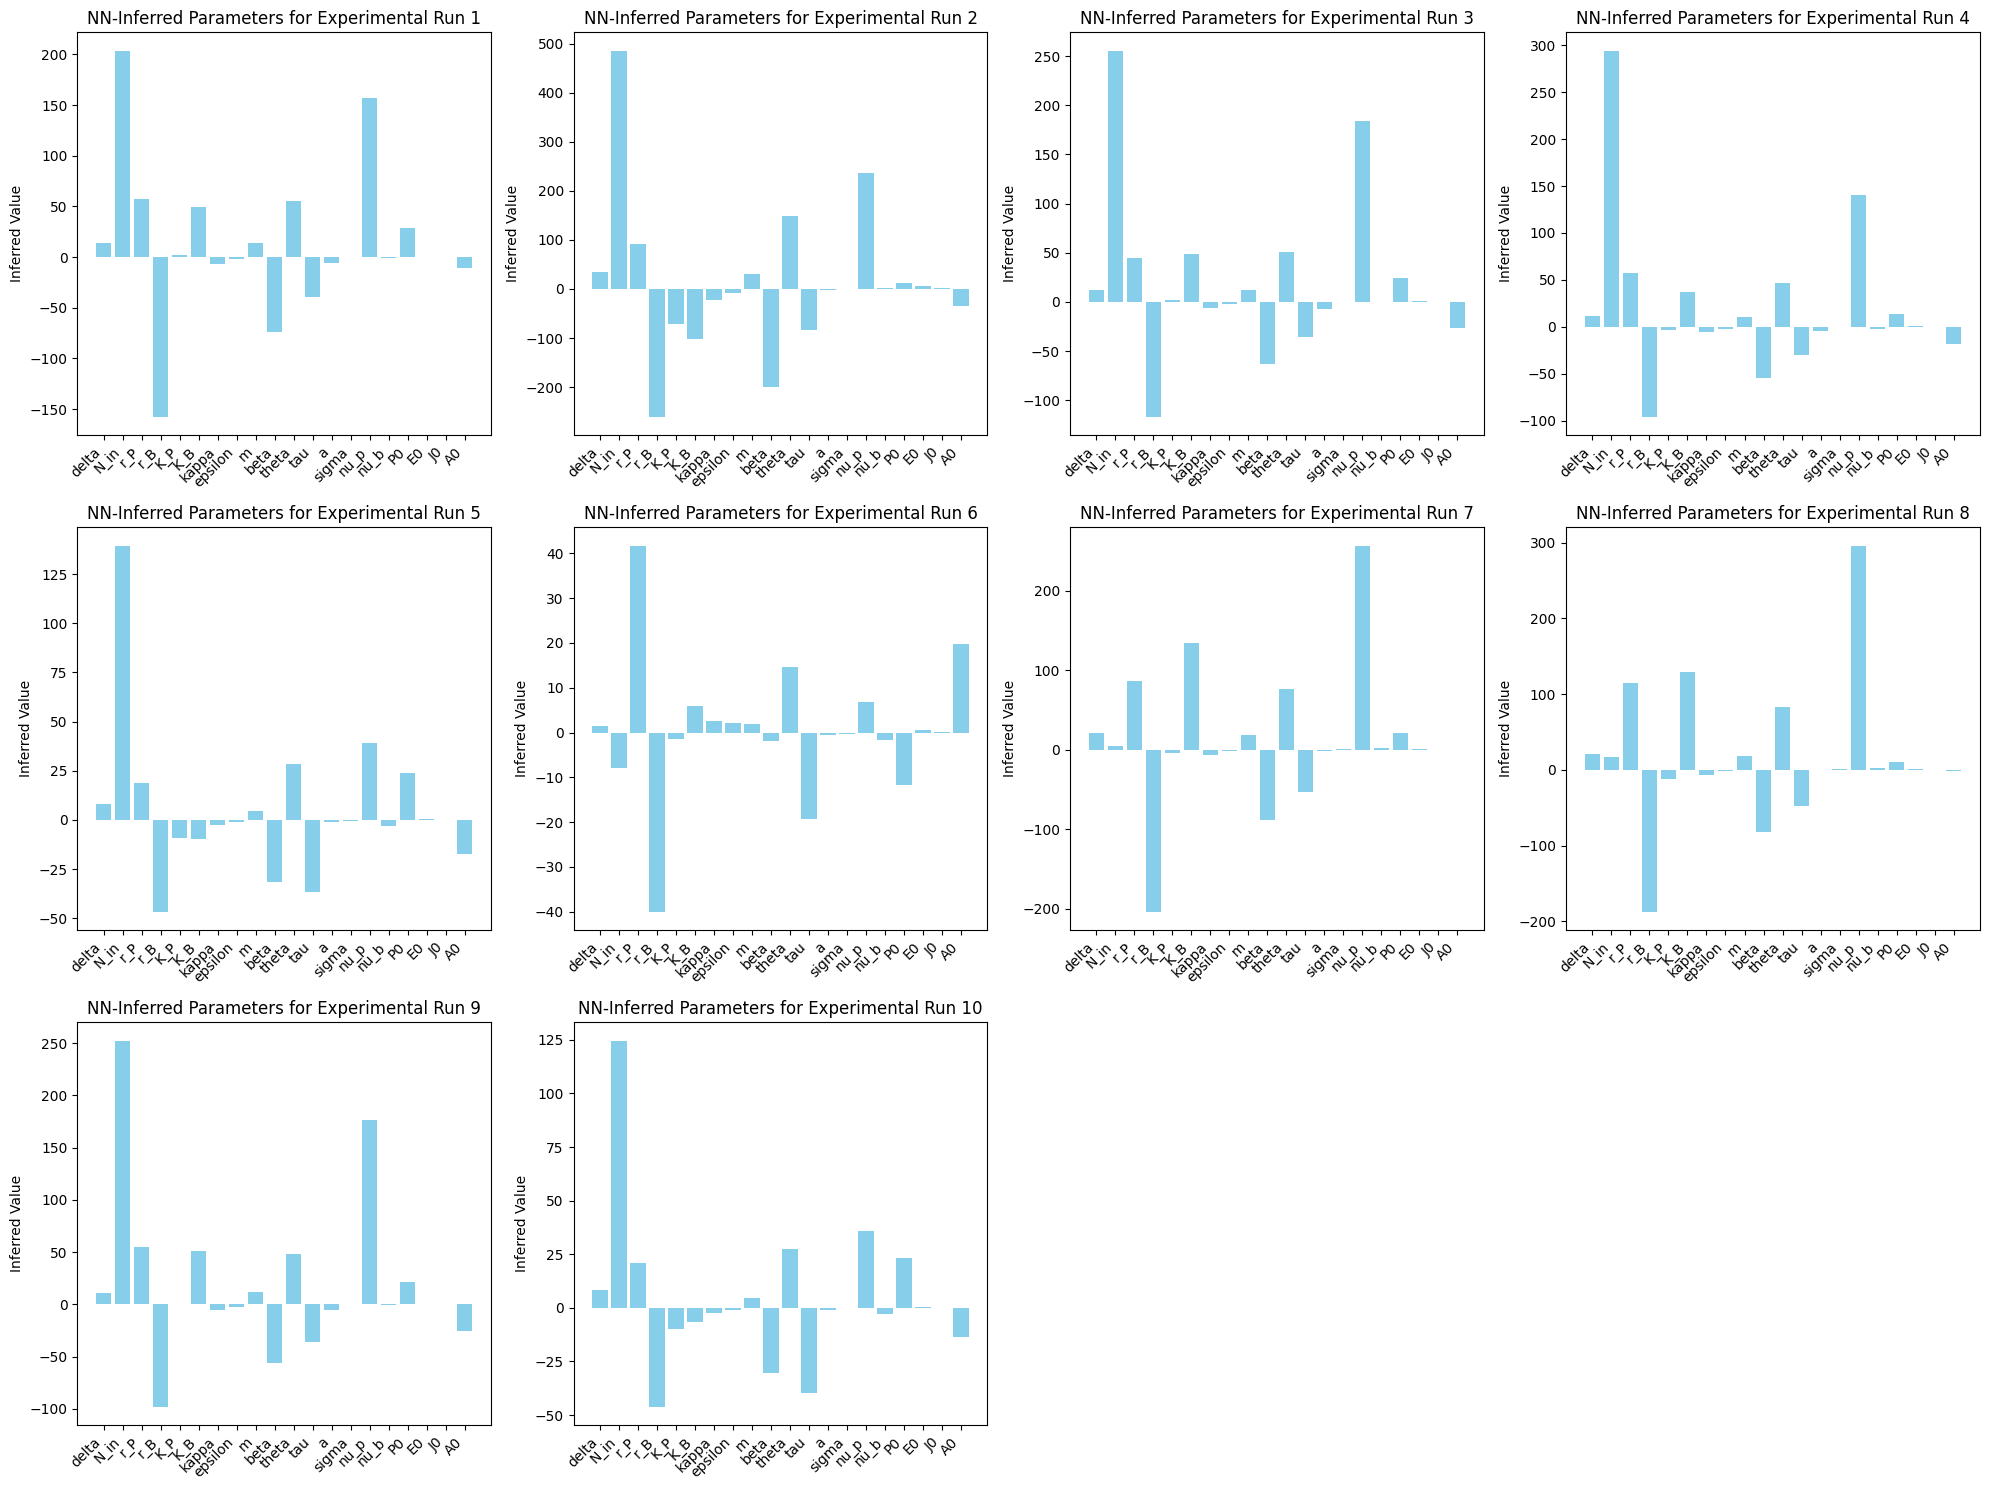

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Set the number of columns for the grid
num_columns = 4
num_rows = int(np.ceil(len(experimental_data) / num_columns))

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Iterate over the experimental data and plot each chart
for i, exp in enumerate(experimental_data):
    # --- Drop extra variables if needed ---
    if exp.shape[0] > 5:
        exp = exp[:5, :]  # Match training input (e.g. algae, rotifers, eggs, egg_ratio, dead)

    # --- Truncate or pad time steps to 400 ---
    expected_timesteps = 400
    exp_truncated = exp[:, :expected_timesteps] if exp.shape[1] > expected_timesteps else exp

    padded = np.zeros((exp.shape[0], expected_timesteps))
    padded[:, :exp_truncated.shape[1]] = exp_truncated

    flat_input = padded.flatten().reshape(1, -1)

    if flat_input.shape[1] != x_scaler.mean_.shape[0]:
        print(f"[ERROR] Input shape mismatch: {flat_input.shape[1]} vs expected {x_scaler.mean_.shape[0]}")
        continue

    flat_input_scaled = x_scaler.transform(flat_input)

    with torch.no_grad():
        input_tensor = torch.tensor(flat_input_scaled, dtype=torch.float32)
        pred_scaled = model(input_tensor).numpy()
        pred = y_scaler.inverse_transform(pred_scaled).flatten()

    # --- Plot on the correct subplot ---
    ax = axes[i]
    ax.bar(param_names, pred, color='skyblue')
    ax.set_xticklabels(param_names, rotation=45, ha='right')
    ax.set_ylabel("Inferred Value")
    ax.set_title(f"NN-Inferred Parameters for Experimental Run {i+1}")

# Hide any unused axes (if the number of experiments isn't a perfect multiple of the columns)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "all_experiments_params_grid.png"), dpi=300)
plt.show()


In [25]:
def infer_from_padded_experiment(model, x_scaler, y_scaler, csv_path, T_cutoff, param_names, save_path=None):
    df = pd.read_csv(csv_path)
    df_padded = pad_with_zeros_after_T(df.copy(), T_cutoff)
    df_padded = df_padded.drop(columns=['Time'], errors='ignore')
    x_input = df_padded.values.flatten().reshape(1, -1)
    x_scaled = x_scaler.transform(x_input)
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        prediction = model(x_tensor).numpy()
        prediction_unscaled = y_scaler.inverse_transform(prediction)

    # Visualization
    plt.figure(figsize=(10, 5))
    sns.barplot(x=param_names, y=prediction_unscaled[0])
    plt.xticks(rotation=45)
    plt.ylabel("Predicted Parameter Value")
    plt.title("Parameter Inference from Experimental Data")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

    return prediction_unscaled